In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

pd.set_option('display.width', 1000)
import numpy as np
import time
import datetime
import i2bmi
import pickle
from pandas.core.tools.datetimes import _guess_datetime_format_for_array
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
import itertools
from itertools import product


import os
import pandasql as ps

import gc
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn3
import upsetplot


from scipy import stats

import seaborn as sns
import kaleido
import plotly.graph_objects as go


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


i2bmi.jupyter_widen()

In [ ]:
#import I2 Sepsis Functions
import I2_Sepsis

In [ ]:
from sqlalchemy import create_engine
# Postgres username, password, and database name
POSTGRES_ADDRESS = '127.0.0.1' ## INSERT YOUR DB ADDRESS
POSTGRES_PORT = '5432' ## INSERT YOUR PORT (DEFAULT IS 5432)
POSTGRES_USERNAME = 'postgres' ## INSERT YOUR POSTGRES USERNAME
POSTGRES_PASSWORD = 'password' ## INSERT YOUR POSTGRES PASSWORD
POSTGRES_DBNAME = 'mimiciv'  ## INSERT YOUR POSTGRES DATABASE NAME


# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))

# Create the connection
cnx = create_engine(postgres_str)

In [ ]:
### SQL QUREIES TO GENERATE THE MIMINIMAL SEPSIS DATA MODEL AND MIMIC GENERATED SOFA, SOI, SOFA, AND SEPSIS DETERMINATIONS TO CHECK AGAINST

adt_sql ='''WITH adt AS (SELECT
    all_adt.subject_id, -- col_id
    all_adt.hadm_id, -- adt_id
    all_adt.admittime, -- adt_admit 
    all_adt.dischtime, -- adt_discharge
    (admittime - dischtime) as LOS
FROM mimic_core.admissions as all_adt
INNER JOIN mimic_derived.icustay_times as icu
ON all_adt.hadm_id = icu.hadm_id)
SELECT * FROM adt'''


icu_adt = '''WITH icu_adt AS(SELECT *
            FROM mimic_derived.icustay_times)
            SELECT * FROM icu_adt'''

abxdf_sql = '''SELECT * FROM mimic_derived.antibiotic'''

cxdf_sql = '''WITH cx AS (select micro_specimen_id
    -- the following columns are identical for all rows of the same micro_specimen_id
    -- these aggregates simply collapse duplicates down to 1 row
    , MAX(subject_id) AS subject_id
    , MAX(hadm_id) AS hadm_id
    , CAST(MAX(chartdate) AS DATE) AS chartdate
    , MAX(charttime) AS charttime
    , MAX(spec_type_desc) AS spec_type_desc
    , max(case when org_name is not null and org_name != '' then 1 else 0 end) as PositiveCulture
  from mimic_hosp.microbiologyevents
  group by micro_specimen_id)
  SELECT * FROM cx'''


demodf_sql = """SELECT subject_id, hadm_id, stay_id,admittime, dischtime, los_hospital,los_icu, admission_age,gender,ethnicity,hospital_expire_flag,dod
FROM mimic_derived.icustay_detail"""


mvdf_sql = '''WITH mv AS (SELECT
    icustay_detail.subject_id,
    mimic_derived.ventilation.stay_id,
    mimic_derived.ventilation.starttime as vent_start,
    mimic_derived.ventilation.endtime as vent_end,
    mimic_derived.ventilation.ventilation_status
FROM mimic_derived.ventilation -- some stays include multiple ventilation events
JOIN mimic_derived.icustay_detail
    ON mimic_derived.ventilation.stay_id = mimic_derived.icustay_detail.stay_id)
    SELECT * FROM mv'''

dxdf_sql = '''WITH dx AS (SELECT
    mimic_core.admissions.subject_id, -- Subject ID
    mimic_hosp.diagnoses_icd.hadm_id,  -- adt_id
    mimic_hosp.diagnoses_icd.icd_code, -- ICD code number
    mimic_hosp.diagnoses_icd.icd_version, --ICD version number
    mimic_core.admissions.dischtime -- dx_time (note that this is discharge time and not diagnosis time)
FROM mimic_hosp.diagnoses_icd
JOIN mimic_core.admissions
    ON mimic_hosp.diagnoses_icd.hadm_id = mimic_core.admissions.hadm_id)
    SELECT * FROM dx'''

vasodf_sql = '''
WITH pressors AS (WITH drugs AS((
-- This query extracts dose+durations of phenylephrine administration
select
  stay_id, linkorderid
  , rate as rate
  , rateuom as rate_uom
  , amount as total_dose
  , starttime
  , endtime
  ,'phenylephrine' as drug
from mimic_icu.inputevents
where itemid = 221749 -- phenylephrine
	)
	
UNION
(
-- This query extracts dose+durations of dopamine administration
select
stay_id, linkorderid
, rate as rate
, rateuom as rate_uom
, amount as total_dose
, starttime
, endtime
,'dobutamine' as drug
from mimic_icu.inputevents
where itemid = 221653 -- dobutamine
	)

UNION ( 
-- This query extracts dose+durations of dopamine administration
select
stay_id, linkorderid
, rate as rate
, rateuom as rate_uom
, amount as total_dose
, starttime
, endtime
, 'dopamine' as drug
from mimic_icu.inputevents
where itemid = 221662 -- dopamine
)

UNION ( 
-- This query extracts dose+durations of norepinephrine administration
select
  stay_id, linkorderid
  , rate as rate
  , rateuom as rate_uom
  , amount as total_dose
  , starttime
  , endtime
  ,'norepinephrine' as drug
from mimic_icu.inputevents
where itemid = 221906 -- norepinephrine
)
	
UNION (
-- This query extracts dose+durations of epinephrine administration
select
stay_id, linkorderid
, rate as rate
, rateuom as rate_uom
, amount as total_dose
, starttime
, endtime
, 'epinephrine' as drug
from mimic_icu.inputevents
where itemid = 221289 -- epinephrine
)
UNION (
-- This query extracts dose+durations of vasopressin administration
select
  stay_id, linkorderid
  , rate as rate
  , rateuom as rate_uom
  , amount as total_dose
  , starttime
  , endtime
, 'vasopressin' as drug
from mimic_icu.inputevents
where itemid = 222315 -- vasopressin)
)),
cohort AS (
  select stay_id, hadm_id, subject_id
  from mimic_icu.icustays
)
(SELECT * FROM drugs LEFT JOIN cohort ON cohort.stay_id = drugs.stay_id))

SELECT subject_id,hadm_id,rate,rate_uom,starttime as vaso_start,endtime as vaso_end, drug FROM pressors
'''



lvdf_sql = '''WITH lvdf AS ((
SELECT subject_id,charttime as time,bicarbonate as val, 'bicarb' as mark, hadm_id
FROM mimic_derived.chemistry
WHERE bicarbonate IS NOT NULL
)
UNION
(
SELECT subject_id, charttime as time, bun as val, 'bun' as mark, hadm_id
FROM mimic_derived.chemistry
WHERE bun IS NOT NULL
)
UNION
(
SELECT subject_id, charttime as time,creatinine as val, 'cr' as mark, hadm_id
FROM mimic_derived.chemistry
WHERE creatinine IS NOT NULL
)
UNION
(
SELECT subject_id ,charttime as time,wbc as val, 'wbc' as mark, hadm_id
FROM mimic_derived.blood_differential
WHERE wbc IS NOT NULL
)
UNION
(
SELECT subject_id,charttime as time,po2 as val, 'pO2' as mark, hadm_id
FROM mimic_derived.bg
WHERE po2 IS NOT NULL and specimen_pred = 'ART.'
)
UNION
(
SELECT subject_id,charttime as time,fio2 as val, 'fio2' as mark, hadm_id
FROM mimic_derived.bg
WHERE fio2 IS NOT NULL and specimen_pred = 'ART.'
)
UNION
(
SELECT subject_id,charttime as time, fio2_chartevents as val, 'fio2' as mark, hadm_id
FROM mimic_derived.bg
WHERE fio2_chartevents IS NOT NULL and specimen_pred = 'ART.'
)
UNION
(
SELECT subject_id, charttime as time,bilirubin_total as val, 'bili' as mark, hadm_id
FROM mimic_derived.enzyme
WHERE bilirubin_total IS NOT NULL 
)
UNION
(
SELECT subject_id ,charttime as time,platelet as val, 'plt' as mark, hadm_id
FROM mimic_derived.complete_blood_count 
WHERE platelet IS NOT NULL 
)
UNION
(
SELECT gcs_t.subject_id, gcs_t.charttime as time, gcs_t.gcs as val, 'gcs' as mark, stay.hadm_id
FROM mimic_derived.gcs as gcs_t JOIN mimic_derived.icustay_detail as stay
ON gcs_t.stay_id = stay.stay_id
WHERE gcs_t.gcs IS NOT NULL
)
UNION
(
SELECT vs.subject_id, vs.charttime as time,mbp as val, 'map' as mark, stay.hadm_id
FROM mimic_derived.vitalsign as vs JOIN mimic_derived.icustay_detail as stay
ON vs.stay_id = stay.stay_id
WHERE vs.mbp IS NOT NULL
)
UNION
(
SELECT vs.subject_id,vs.charttime as time,spo2 as val, 'spo2' as mark, stay.hadm_id
FROM mimic_derived.vitalsign as vs JOIN mimic_derived.icustay_detail as stay
ON vs.stay_id = stay.stay_id
WHERE vs.spo2 IS NOT NULL 
)
UNION
(
SELECT vs.subject_id, vs.charttime as time, heart_rate as val, 'hr' as mark, stay.hadm_id
FROM mimic_derived.vitalsign as vs JOIN mimic_derived.icustay_detail as stay
ON vs.stay_id = stay.stay_id
WHERE vs.spo2 IS NOT NULL 
)
UNION
(
SELECT vs.subject_id, vs.charttime as time,vs.resp_rate as val, 'rr' as mark, stay.hadm_id
FROM mimic_derived.vitalsign as vs JOIN mimic_derived.icustay_detail as stay
ON vs.stay_id = stay.stay_id
WHERE vs.resp_rate IS NOT NULL 
)
UNION
(
SELECT vs.subject_id, vs.charttime as time,vs.sbp as val, 'sbp' as mark, stay.hadm_id
FROM mimic_derived.vitalsign as vs JOIN mimic_derived.icustay_detail as stay
ON vs.stay_id = stay.stay_id
WHERE vs.sbp IS NOT NULL 
)
UNION
(
SELECT O2.subject_id, O2.charttime as time,O2.o2_flow as val, 'O2 Flow' as mark, stay.hadm_id
FROM mimic_derived.oxygen_delivery as O2 JOIN mimic_derived.icustay_detail as stay
ON O2.stay_id = stay.stay_id
WHERE O2.o2_flow IS NOT NULL 
))
SELECT * FROM lvdf'''


Sepsis3_sql = '''WITH sepsis as (SELECT sep3.*,details.hadm_id
FROM mimic_derived.sepsis3 as sep3
INNER JOIN mimic_derived.icustay_detail as details
ON sep3.subject_id = details.subject_id AND sep3.stay_id = details.stay_id)
SELECT * FROM sepsis
'''

SOI_sql = '''WITH SOI as (SELECT *
FROM mimic_derived.suspicion_of_infection)
SELECT * FROM SOI'''

SOFA_sql = '''SELECT
       subject_id, sep3.stay_id, hadm_id, icu_intime, icu_outtime, starttime, endtime,
       bilirubin_max, liver, liver_24hours, 
       meanbp_min,
       rate_dobutamine, rate_dopamine, rate_epinephrine,rate_norepinephrine,
       
       cardiovascular,cardiovascular_24hours,
       
       gcs_min,cns, cns_24hours, 
       platelet_min, coagulation,coagulation_24hours,
       creatinine_max, uo_24hr, renal, renal_24hours,
       pao2fio2ratio_novent, pao2fio2ratio_vent, respiration, respiration_24hours,
       sofa_24hours   

FROM mimic_derived.sofa AS sep3
LEFT JOIN mimic_derived.icustay_detail as detail
ON sep3.stay_id = detail.stay_id'''


Sepsis_codes_sql = """WITH dx as (SELECT dx.subject_id, dx.hadm_id, dx.icd_code, dx.icd_version, icd_key.long_title
FROM mimic_hosp.diagnoses_icd as dx
INNER JOIN mimic_hosp.d_icd_diagnoses as icd_key
ON dx.icd_code = icd_key.icd_code AND dx.icd_version = icd_key.icd_version
WHERE dx.icd_code  IN ('A419','A409','A412','A4101','A4102','A411','A403','A414','A4150','A413','A4151','A4152','A4153','A4159','A4189','A021','A227','A267',
 'A327','A400','A401','A408','A4181','A427','A5486','B377','99591','0389','0380','03810','03811','03812','03819','0382','03840','03841','03842',
 '03843','03844','03849','0388','99592','R6520','78552','R6521'))
 SELECT * FROM dx
"""

uo_sql =  """WITH UOP AS (SELECT times.subject_id,times.hadm_id,uo.charttime,

CASE WHEN uo.uo_tm_24hr >= 22 AND uo.uo_tm_24hr <= 30
          THEN uo.urineoutput_24hr / uo.uo_tm_24hr * 24 END AS uo_24hr


FROM mimic_derived.urine_output_rate uo
LEFT JOIN mimic_derived.icustay_times times
ON uo.stay_id = times.stay_id) SELECT subject_id, hadm_id, charttime as uo_time, uo_24hr FROM UOP"""

sql_scripts = {'adt':adt_sql,'icu_adt':icu_adt, 'vasodf': vasodf_sql, 'abxdf':abxdf_sql,'cxdf':cxdf_sql, 'demo':demodf_sql, 
               'mvdf':mvdf_sql,'dxdf':dxdf_sql,'uo':uo_sql, 'lvdf':lvdf_sql,'Sepsis3':Sepsis3_sql,'SOI':SOI_sql, 'SOFA': SOFA_sql, 
               'ICD_codes':Sepsis_codes_sql}

In [ ]:
### FUNCTION TO LOAD DATA FROM MIMIC
def load_mimic(limit=None):
    data ={}
    if limit != None:
        print('loading adt')
        adt = pd.read_sql_query(sql_scripts['adt'] +' LIMIT {}'.format(limit), cnx).drop_duplicates().reset_index(drop=True)
        adt['admittime'] = pd.to_datetime(adt['admittime'],utc=True)
        adt['dischtime'] = pd.to_datetime(adt['dischtime'],utc=True)
        first = adt.sort_values(by ='admittime', ascending=True).groupby(['subject_id','hadm_id']).first().reset_index()
        last = adt.sort_values(by ='dischtime',ascending = True).groupby(['subject_id','hadm_id']).last().reset_index()
        adt = pd.merge(first.drop('dischtime',axis=1),last[['subject_id','hadm_id','dischtime']], on=['subject_id','hadm_id'], how='left')
        
        data['adt'] = adt
        
        include_subject_id = tuple(adt['subject_id'].to_list())
        include_hadm_id = tuple(adt['hadm_id'].to_list())
        
        for script in sql_scripts.keys()-['adt','Sepsis3']:
            curtime = time.time()
            print('loading {}'.format(script),end='...')
            data[script] = pd.read_sql_query(sql_scripts[script] +' WHERE subject_id IN {}'.format(include_subject_id), cnx).drop_duplicates().reset_index(drop=True)
            print(f'({time.time()-curtime:.1f}s)')
        
        for script in ['Sepsis3','SOFA']:
            curtime = time.time()
            print('loading {}'.format(script),end='...')
            data[script] = pd.read_sql_query(sql_scripts[script] +' WHERE hadm_id IN {}'.format(include_hadm_id), cnx).drop_duplicates().reset_index(drop=True)
            print(f'({time.time()-curtime:.1f}s)')
 
    else:
        for script in sql_scripts:
            curtime = time.time()
            print('loading {}'.format(script),end='...')
            data[script] = pd.read_sql_query(sql_scripts[script],cnx).drop_duplicates().reset_index(drop=True)
            print(f'({time.time()-curtime:.1f}s)')

        data['adt']['admittime'] = pd.to_datetime(data['adt']['admittime'],utc=True)
        data['adt']['dischtime'] = pd.to_datetime(data['adt']['dischtime'],utc=True)
        first = data['adt'].sort_values(by ='admittime', ascending=True).groupby(['subject_id','hadm_id']).first().reset_index()
        last = data['adt'].sort_values(by ='dischtime',ascending = True).groupby(['subject_id','hadm_id']).last().reset_index()
        data['adt'] = pd.merge(first.drop('dischtime',axis=1),last[['subject_id','hadm_id','dischtime']], on=['subject_id','hadm_id'], how='left')

    
    return data

In [ ]:
#LOAD DATA AND CONVERT DATA TYPES 
#CONIDER USING THE data = load_mimic(500) TO LOAD A SMALLER PORTION OF THE DATABASE TO SAVE TIME OR MEMORY

#data = load_mimic(500)
data = load_mimic()



print('\n')
data['adt']['subject_id'] = data['adt']['subject_id'].dropna().astype(int).astype(str)
data['adt']['hadm_id'] = data['adt']['hadm_id'].dropna().astype(int).astype(str)
data['adt']['admittime'] = pd.to_datetime(data['adt']['admittime'],utc=True,errors='raise',exact=False,infer_datetime_format=True)
data['adt']['dischtime'] = pd.to_datetime(data['adt']['dischtime'],utc=True,errors='raise',exact=False,infer_datetime_format=True)

data['adt'] = data['adt'].groupby(['subject_id','hadm_id']).agg({'admittime':'min','dischtime':'max'}).reset_index()

data['adt'].dropna(inplace=True)
data['adt'].reset_index(drop=True,inplace=True)

dfs = list(data.keys())
dfs.remove('adt')



for df in dfs:
    if 'subject_id' in data[df].columns:
        data[df]['subject_id'] = data[df]['subject_id'].astype(int).astype(str)
        #data[df].dropna(subset=[col_dict['col_id']],inplace=True)
        data[df].reset_index(drop=True,inplace=True)
        
    for col in ['admittime','dischtime','intime_hr','outtime_hr','time','vent_start', 'vent_end','vaso_start','vaso_end','starttime','stoptime','charttime']:
        if col in data[df].columns:
            data[df][col] = pd.to_datetime(data[df][col],utc=True)
    
                                                         
    if 'hadm_id' in data[df].columns:
        data[df]['hadm_id'] = pd.to_numeric(data[df]['hadm_id'],errors='coerce',downcast='integer').astype(str)
        data[df]['hadm_id'] = data[df]['hadm_id'].apply(lambda z: z.split('.')[0])
        data[df].reset_index(drop=True,inplace=True)      
        
        
    #print(df)
    #display(data[df].head())
    #print('percent in adt: {:.2f}'.format(data[df]['subject_id'].isin(data['adt']['subject_id']).mean()*100))
    #print('')

In [ ]:
#DROP MISSING VALUES THAT ARE NEEDED
data['cxdf'].dropna(subset=['charttime'],inplace=True)
data['abxdf'].dropna(subset=['starttime'],inplace=True)
data['icu_adt'] = data['icu_adt'].dropna(subset=['intime_hr','outtime_hr'],how='all').reset_index(drop=True)
data['uo'] = data['uo'].dropna()

In [ ]:
# CHANGE ADT TO CORRECT FORMAT FOR MINIMAL SEPSIS DATA MODEL
def make_adt(adt,icu_adt):

    adt_trim = adt.copy()
    adt_trim['admittime'] = pd.to_datetime(adt_trim['admittime'],utc=True)
    adt_trim['dischtime'] = pd.to_datetime(adt_trim['dischtime'],utc=True)
    

    
    adt_icu_trim = icu_adt.copy()
    adt_icu_trim = adt_icu_trim[['subject_id','hadm_id','intime_hr','outtime_hr']]
    adt_icu_trim['intime_hr'] =  pd.to_datetime(adt_icu_trim['intime_hr'],utc=True)
    adt_icu_trim['outtime_hr'] = pd.to_datetime(adt_icu_trim['outtime_hr'],utc=True)
    

    

    find_last_adt = adt_trim.sort_values(by='dischtime').groupby('hadm_id')['dischtime'].last().reset_index()
    find_last_icu = adt_icu_trim.sort_values(by='outtime_hr').groupby('hadm_id')['outtime_hr'].last().reset_index()
    find_last = pd.merge(find_last_adt,find_last_icu,on='hadm_id',how='left')
    

    find_first_adt = adt_trim.sort_values(by='admittime').groupby('hadm_id')['admittime'].first().reset_index()
    find_first_icu = adt_icu_trim.sort_values(by='intime_hr').groupby('hadm_id')['intime_hr'].first().reset_index()
    find_first = pd.merge(find_first_adt,find_first_icu,on='hadm_id',how='left')
    
    find_last['last_time']= find_last[['dischtime','outtime_hr']].max(axis=1,skipna=True, numeric_only=False)
    adt_trim = pd.merge(adt_trim,find_last,on='hadm_id',how='left')
    adt_trim['dischtime'] = adt_trim['last_time']
    
    find_first['first_time'] = find_first[['admittime','intime_hr']].min(axis=1,skipna=True, numeric_only=False)
    adt_trim = pd.merge(adt_trim,find_first,on='hadm_id',how='left')
    adt_trim['admittime'] = adt_trim['first_time']
    
    
    adt_icu_trim['loc_cat'] = 'ICU'
    
    
    adt_trim = adt_trim[['subject_id','hadm_id','admittime','dischtime']].rename(columns={'admittime':'intime_hr','dischtime':'outtime_hr'})

    
    combine = pd.concat([adt_trim,adt_icu_trim])
    combine['intime_hr'] = pd.to_datetime(combine['intime_hr'],utc=True)
    combine['outtime_hr'] = pd.to_datetime(combine['outtime_hr'],utc=True)
    
    
    df = combine.groupby(['subject_id','hadm_id']).agg({'intime_hr':lambda z: list(z),'outtime_hr':lambda z: list(z)}).reset_index()
    df['all_times'] = df['intime_hr'] + df['outtime_hr']
    df = df[['subject_id','hadm_id','all_times']].explode('all_times').sort_values(by=['subject_id','hadm_id','all_times']).reset_index(drop=True)

    
    
    df['outtime_hr'] = df.groupby(['subject_id','hadm_id'])['all_times'].shift(-1)
    df = df.dropna().rename(columns={'all_times':'intime_hr'})

    df['duration'] = (df['outtime_hr'] - df['intime_hr']).apply(lambda z: z.total_seconds()/3600)
    df = df[df['duration']>0].reset_index(drop=True)
    df = pd.merge(df,adt_icu_trim[['subject_id','hadm_id','intime_hr','loc_cat']],on=['subject_id','hadm_id','intime_hr'],how='left').fillna('non-ICU')
    
    df = pd.merge(df,adt[['subject_id','hadm_id','admittime','dischtime']],on=['subject_id','hadm_id'], how='left')
    
    return df.dropna()

In [ ]:
#FINALIZE DATAFRAMES
lvdf = data['lvdf'].copy()
adt = make_adt(data['adt'],data['icu_adt'])
vasodf = data['vasodf'].copy()
dxdf = data['dxdf'].copy()
mvdf = data['mvdf'].copy()
abxdf = data['abxdf'].copy()
cxdf = data['cxdf'].copy()
demo = data['demo'].copy()
Sepsis3_key = data['Sepsis3'].copy()
uo = data['uo'].copy()

### Map Columns to Data Model

In [ ]:
#MAP CURRENT COLUMN NAMES TO THE COLUMNS IN THE MINIMAL SEPSIS DATA MODEL
names_to_standard = {
            'subject_id' : 'patient_id', 
            'hadm_id' : 'encounter_id', 
            'admittime' : 'admit_time', 
            'dischtime' : 'discharge_time',
            'adt_loc': 'location',
            'intime_hr': 'location_start',
            'outtime_hr':'location_end',
        
            
            
            'val' : 'value', 
            'mark' : 'label', 
            'time' : 'time_measured', 
            
            
            'vent_start': 'vent_start',
            'vent_end':'vent_end',
            'ventilation_status': 'vent_type',
            
            
            'vaso_start': 'vaso_start',
            'vaso_end': 'vaso_end',
            'rate_uom': 'vaso_units',
            'rate': 'vaso_dose',
            'drug': 'pressor_name',
            

            'starttime':'abx_start',
            'stoptime': 'abx_end',
            'antibiotic' : 'antibiotic_name',
            
            
            'charttime': 'culture_time',
            'spec_type_desc': 'culture_type',
    
            'icd_code' : 'dx_code',
            'recorded_date' : 'dx_time',
    
            'uo_time':'uo_time'
       }

In [ ]:
# RENAME COLUMNS
dfs = [lvdf, adt, vasodf, dxdf, mvdf, abxdf, cxdf, demo , Sepsis3_key , uo]
for df in dfs:
    df.rename(columns=names_to_standard,inplace=True)
    display(df.head())

In [ ]:
# DROP COLUMNS THAT ARE NOT NEEDED
adt = adt.drop(columns=['admit_time','discharge_time'])
vasodf = vasodf.drop(columns=['encounter_id'])
lvdf = lvdf.drop(columns=['encounter_id'])
mvdf = mvdf.drop(columns=['stay_id'])
abxdf = abxdf.drop(columns=['encounter_id','stay_id'])
cxdf = cxdf.drop(columns=['encounter_id','micro_specimen_id','chartdate','positiveculture'])
uo = uo.drop(columns=['encounter_id'])


In [ ]:
#REMOVE NON INVASIVE VENTILATED PATIENTS AS THIS IS THE DECISION IN MIMICS CONCEPTION OF SEPSIS-3
display(pd.DataFrame(mvdf['vent_type'].value_counts()))
mvdf = mvdf[mvdf['vent_type'].isin(['InvasiveVent'])].reset_index(drop=True)
mvdf.loc[mvdf['vent_type']=='InvasiveVent','vent_type']='VENT'

In [ ]:
# REMOVE PRESSORS OTHER THAN 'norepinephrine','epinephrine','dopamine','dobutamine' AS THIS WAS THE DECISION MADE BY MIMIC
display(pd.DataFrame(vasodf['pressor_name'].value_counts()))
vasodf = vasodf[vasodf['pressor_name'].isin(['norepinephrine','epinephrine','dopamine','dobutamine'])].reset_index(drop=True)

### Import Dataframes

## Goals:
1. To develop a data structure that is easy to format data from EHRs into and contains the data elements most commonly used to calculate clinical scores
2. To create sub-fuctions to gather data and facilitate the writing of clinical calculators
3. To create a sub-set of clinical calculaors focusing on common scores in the ICU and hospital populations
4. To use MIMIC data as a proof on concepts and to facilitate peer review of the calculated scores

### Map lvdf lables to Data Model Lables

In [ ]:
# CURRENT LABELS
lvdf['label'].value_counts()

In [ ]:
# MAP CURRENT LABELS TO LABELS REQUIRED BY THE MINIMAL SEPSIS DATA MODEL
lvdf_map = {#'TEMP' : 'temp_c', 
            'HR' : 'hr', 
            'RR' :  'rr',
            #'PCO2': 'pco2_art',
            'WBC' : 'wbc',
            'SBP' : 'sbp',
            'MAP' : 'map',
            #'LACTATE' : 'lactate',
            'Cr' : 'cr',
            'BILI' : 'bili',
            'PLT' : 'plt',
            #'INR' : 'inr',
            #'PT' : 'pt',
            'GCS' : 'gcs',
            'FiO2': 'fio2',
            'O2_Flow': 'O2 Flow',
            'SpO2' : 'spo2',
            'BUN' : 'bun',
            #'PT' : 'pt',
            #'UOP' : np.nan,
            'FiO2' : 'fio2',
            #'pH' : 'ph_art',
            'pO2' : 'pO2',
            #'AaGradient' : np.nan,
            #'Na': 'na',
            #'K' : 'k',
            #'HCT' : 'hcrt',
            #'PTT': 'ptt',
            #'PEEP': 'peep',
            #'PFRatio': np.nan,
            #'SFRatio': np.nan,
           }

inv_map = {v: k for k, v in lvdf_map.items() if pd.notna(k)}

lvdf['label']  = lvdf['label'].map(inv_map)
lvdf['time_measured'] = pd.to_datetime(lvdf['time_measured'],utc=True)
lvdf.drop_duplicates(inplace= True)


lvdf['label'].value_counts()

In [ ]:
# DROP ANY UNKNOWN LABELS
lvdf = lvdf[~lvdf['value'].isna()]

#### Explore Abx

In [ ]:
abxdf['abx_start'] = pd.to_datetime(abxdf['abx_start'],utc=True)
abxdf['abx_end'] = pd.to_datetime(abxdf['abx_end'],utc=True)

In [ ]:
abx_map = pd.read_excel('MIMIC_abx_review.xlsx')[['antibiotic','route','route_corrected']].rename(columns={'antibiotic':'antibiotic_name'})

In [ ]:
abx_explore = pd.merge(abxdf,abx_map,on=['antibiotic_name','route'],how='left')

In [ ]:
abx_explore[~abx_explore['route_corrected'].isin(['PO','IV'])]['route_corrected'].value_counts()

In [ ]:
inappropriate_route = abx_explore[abx_explore['route_corrected'].isin(['Dwell','Topical','Irrigation','Inhaled'])]

In [ ]:
#inappropriate_route

In [ ]:
inappropriate_route = inappropriate_route.groupby(['antibiotic_name','route','route_corrected'])['patient_id'].count().reset_index().rename(columns={'patient_id':'count'})

In [ ]:
inappropriate_drug = abx_explore[abx_explore['antibiotic_name'].str.contains('nitro',case=False)]

In [ ]:
inappropriate_drug 

In [ ]:
inappropriate_drug  =inappropriate_drug.groupby(['antibiotic_name','route','route_corrected'])['patient_id'].count().reset_index().rename(columns={'patient_id':'count'})

In [ ]:
inappropriate_abx = pd.concat([inappropriate_route,inappropriate_drug]).reset_index(drop=True)

In [ ]:
#innappropriate_abx 

#### Explore Cx

In [ ]:
cx_final = cxdf
#cx_final = cxdf[cxdf['variable']=='BLOOD CULTURE'].reset_index(drop=True)

In [ ]:
cx_map = pd.read_excel('MIMIC_cx_review-MH-2-24-22.xlsx')[['spec_type_desc','Description']].rename(columns={'spec_type_desc':'culture_type'})

In [ ]:
cx_explore = pd.merge(cxdf,cx_map,on='culture_type',how='left')

In [ ]:
inappropriate_cx = cx_explore[cx_explore['Description'].isin(['Screen','Viral Chronic','Non-Sepsis Infection','Non-Culture','Postmortem','Non-Sterile Culture','Screening'])].reset_index(drop=True)
inappropriate_cx = inappropriate_cx.groupby('culture_type')['patient_id'].count().reset_index().rename(columns={'patient_id':'count'})

#### Sepsis Calcs

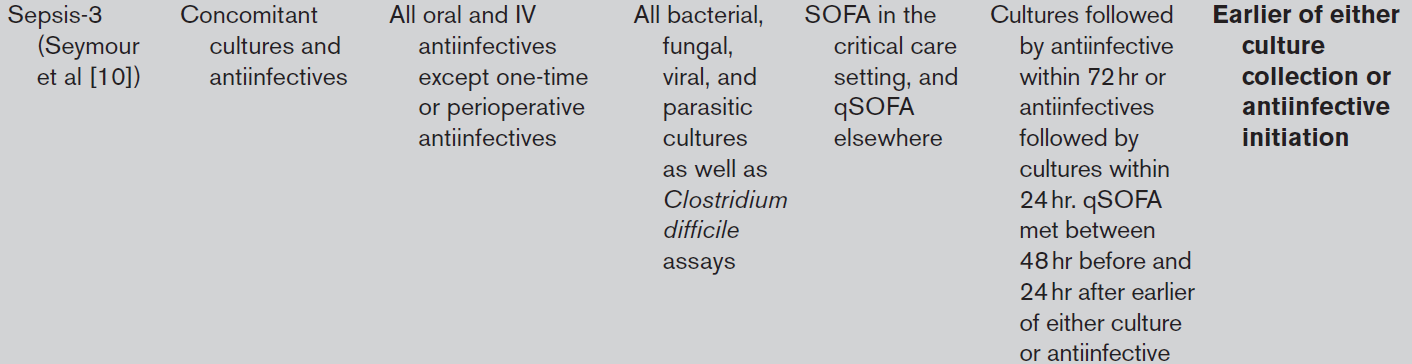

### Run Sepsis-3

In [ ]:
SOI_full, RTI_full, Sep_3,SOI_final,RTI_final = I2_Sepsis.Sepsis_3(lvdf=lvdf, adt=adt, mvdf= mvdf, abxdf = abxdf, cxdf= cx_final, vasodf = vasodf, uodf=uo, demo=demo, SF_dict = {1:512,2:357,3:214,4:89}, calc_FiO2 = False, calc_PF = True, calc_SF= False, 
max_flow_convert= 6, calc_interval_mins = 60, LOCF_hours = None, include_SF_RATIO = False, include_qSOFA =False,mech_vent_def = 'VENT', gcs_cutoff = 15, debug = True, cutoff = 2)

### Make Copy of Originals and Ensure Formats Are Correct:

In [ ]:
Sep_3_orig = Sep_3.copy()
RTI_orig = RTI_full.copy()
SOI_orig = SOI_full.copy()

MSep_3 = data['Sepsis3'].copy().rename(columns = names_to_standard)
MIMIC_SOI = data['SOI'].copy().rename(columns = names_to_standard)
MIMIC_SOFA = data['SOFA'].copy().rename(columns={'starttime':'SOFA_start', 'endtime':'SOFA_end'}).rename(columns = names_to_standard)

## Clean up and Format Columns

### Python

In [ ]:
Sep_3['SOITime'] = pd.to_datetime(Sep_3['SOITime'], utc=True)
Sep_3['score_time'] = pd.to_datetime(Sep_3['score_time'], utc=True)
Sep_3['patient_id'] = Sep_3['patient_id'].astype(str)
Sep_3['encounter_id'] = Sep_3['encounter_id'].astype(str)
Sep_3['loc_cat'] = Sep_3['loc_cat'].astype(str)
Sep_3['Score'] = Sep_3['Score'].astype(str)


Sep_3['Sepsis_Time'] = Sep_3['SOITime']
Sep_3 = Sep_3[['patient_id', 'encounter_id', 'SOITime', 'score_time','Sepsis_Time', 'loc_cat', 'Score']]





In [ ]:
RTI = RTI_full[['patient_id', 'encounter_id', 'score_time','SOFA_GCS_Score','SOFA_MAP_Score','SOFA_BILI_Score','SOFA_PLT_Score','SOFA_RENAL_Score','SOFA_RESP_Score','SOFA_Score']].reset_index(drop=True)

RTI['score_time'] = pd.to_datetime(RTI['score_time'],utc=True)
RTI['patient_id'] = RTI['patient_id'].astype(str)
RTI['encounter_id'] = RTI['encounter_id'].astype(str)

In [ ]:
python_SOFA = RTI[['patient_id','encounter_id','score_time','SOFA_GCS_Score','SOFA_MAP_Score','SOFA_BILI_Score','SOFA_PLT_Score','SOFA_RENAL_Score','SOFA_RESP_Score','SOFA_Score']]
#python_qSOFA = RTI[['patient_id','encounter_id','score_time','qSOFA_Score']]

In [ ]:
SOI_trim = SOI_full

SOI_trim['abx_start'] = pd.to_datetime(SOI_trim['abx_start'],utc=True)
SOI_trim['culture_time'] = pd.to_datetime(SOI_trim['culture_time'],utc=True)
SOI_trim['SOITime'] = pd.to_datetime(SOI_trim['SOITime'],utc=True)
SOI_trim['patient_id'] = SOI_trim['patient_id'].astype(str)
SOI_trim['encounter_id'] = SOI_trim['encounter_id'].astype(str)


### SQL

In [ ]:
MSep_3['antibiotic_time'] = pd.to_datetime(MSep_3['antibiotic_time'],utc=True)
MSep_3['culture_time'] = pd.to_datetime(MSep_3['culture_time'],utc=True)
MSep_3['suspected_infection_time'] = pd.to_datetime(MSep_3['suspected_infection_time'],utc=True)
MSep_3['sofa_time'] = pd.to_datetime(MSep_3['sofa_time'],utc=True)
MSep_3['patient_id'] = MSep_3['patient_id'].astype(str)
MSep_3['encounter_id'] = MSep_3['encounter_id'].astype(str)


In [ ]:
# Find time of Sepsis for Mimic

MSep_3['MSep_Time'] = MSep_3['suspected_infection_time']
MSep_3 = MSep_3.sort_values(by='MSep_Time').groupby('encounter_id').first().reset_index()
MSep_3 = MSep_3[['patient_id','encounter_id', 'stay_id', 'antibiotic_time', 'culture_time', 'suspected_infection_time', 
                 'sofa_time','MSep_Time', 'sofa_score', 'respiration', 'coagulation', 'liver', 'cardiovascular', 'cns', 'renal', 'sepsis3']]

In [ ]:
MIMIC_SOI['patient_id']  = MIMIC_SOI['patient_id'].astype(str)
MIMIC_SOI['encounter_id']  = MIMIC_SOI['encounter_id'].astype(str)

MIMIC_SOI['antibiotic_time'] = pd.to_datetime(MIMIC_SOI['antibiotic_time'],utc=True)
MIMIC_SOI['suspected_infection_time'] = pd.to_datetime(MIMIC_SOI['suspected_infection_time'],utc=True)
MIMIC_SOI['culture_time'] = pd.to_datetime(MIMIC_SOI['culture_time'],utc=True)

MIMIC_SOI = MIMIC_SOI[MIMIC_SOI['suspected_infection']==1]


In [ ]:
MIMIC_SOFA['patient_id'] = MIMIC_SOFA['patient_id'].astype(str)
MIMIC_SOFA['encounter_id'] = MIMIC_SOFA['encounter_id'].astype(str)

MIMIC_SOFA['icu_intime'] = pd.to_datetime(MIMIC_SOFA['icu_intime'],utc=True)
MIMIC_SOFA['icu_outtime'] = pd.to_datetime(MIMIC_SOFA['icu_outtime'],utc=True)
MIMIC_SOFA['SOFA_start'] = pd.to_datetime(MIMIC_SOFA['SOFA_start'],utc=True)
MIMIC_SOFA['SOFA_end'] = pd.to_datetime(MIMIC_SOFA['SOFA_end'],utc=True)

### Remove cultures with only date if used for SOI in MIMIC

In [ ]:
raw_cxdf = pd.read_sql('''WITH cx AS (select micro_specimen_id
    -- the following columns are identical for all rows of the same micro_specimen_id
    -- these aggregates simply collapse duplicates down to 1 row
    , MAX(subject_id) AS subject_id
    , MAX(hadm_id) AS hadm_id
    , CAST(MAX(chartdate) AS DATE) AS chartdate
    , MAX(charttime) AS charttime
    , MAX(spec_type_desc) AS spec_type_desc
    , max(case when org_name is not null and org_name != '' then 1 else 0 end) as PositiveCulture
  from mimic_hosp.microbiologyevents
  group by micro_specimen_id)
  SELECT * FROM cx''',cnx)

In [ ]:
no_time = raw_cxdf[raw_cxdf['charttime'].isna()][['subject_id','chartdate','spec_type_desc']].rename(columns={'subject_id':'patient_id','chartdate':'culture_time','spec_type_desc':'specimen'}).reset_index(drop=True)
no_time['patient_id'] = no_time['patient_id'].astype(str)
no_time['culture_time'] = pd.to_datetime(no_time['culture_time'],utc=True)

In [ ]:
df = raw_cxdf.copy()
df.loc[df['charttime'].isna(),'charttime'] = df.loc[df['charttime'].isna(),'chartdate']

df['charttime'] = pd.to_datetime(df['charttime'],utc=True)
df['subject_id'] = df['subject_id'].astype(str)

df = df[['subject_id','charttime']].rename(columns={'subject_id':'patient_id','charttime':'culture_time'})

included_cx = pd.merge(MIMIC_SOI,df,on = ['patient_id','culture_time'],how='inner')

In [ ]:
SOI_by_date = pd.merge(no_time,included_cx, on = ['patient_id','culture_time'], how='inner')[['patient_id','encounter_id', 'culture_time']]

In [ ]:
MSep_3 = MSep_3[~MSep_3['patient_id'].isin(SOI_by_date['patient_id'])].reset_index(drop=True)
MIMIC_SOI = MIMIC_SOI[~MIMIC_SOI['patient_id'].isin(SOI_by_date['patient_id'])].reset_index(drop=True)

Sep_3 = Sep_3[~Sep_3['patient_id'].isin(SOI_by_date['patient_id'])].reset_index(drop=True)
SOI_trim = SOI_trim[~SOI_trim['patient_id'].isin(SOI_by_date['patient_id'])].reset_index(drop=True)

### Take only First SOI

In [ ]:
SOI_trim = SOI_trim.sort_values(by='SOITime').groupby('encounter_id').first().reset_index() #take only first SOI
Sep_3 = pd.merge(Sep_3,SOI_trim[['patient_id','encounter_id','SOITime']],on=['patient_id','encounter_id','SOITime'],how='inner').reset_index(drop=True)

MIMIC_SOI = MIMIC_SOI.sort_values(by='suspected_infection_time').groupby('encounter_id').first().reset_index() #take only first SOI
MSep_3 = pd.merge(MSep_3,MIMIC_SOI[['patient_id','encounter_id','suspected_infection_time']],on=['patient_id','encounter_id','suspected_infection_time'],how='inner').reset_index(drop=True)

### Check Overlap Between Definitions

In [ ]:
Sepsis_codes = data['ICD_codes'].copy().rename(columns=names_to_standard)


set1 = set(Sep_3['encounter_id'].astype(str))
set2 = set(MSep_3['encounter_id'].astype(str))
set3 = set(Sepsis_codes['encounter_id'].astype(str))

venn3([set1, set2,set3], ('Python SOFA Score', 'MIMIC SQL SOFA Score','ICD Code For Sepsis'))

plt.title('Sepsis Definition Overlap',fontsize=20)
plt.savefig('Figure 3.jpeg')
plt.show()

### Look at Differences Again without ICD Codes

In [ ]:
colors = {'ICU': '#e31a1c', 'non-ICU':'#1f78b4','mimic':'#6a3d9a','python':'#33a02c'}

In [ ]:
set1 = set(Sep_3['encounter_id'].astype(str))
set2 = set(MSep_3['encounter_id'].astype(str))

venn2([set1, set2], ('Python Pipeline', 'SQL Pipeline'),set_colors=(colors['python'], colors['mimic']), alpha = 0.9)

plt.title('Sepsis Definition Overlap',fontsize=20)
plt.savefig('Figure 2.jpeg')
plt.show()

### Overlap Exploration

In [ ]:
def find_overlap(df):
    return pd.merge(all_enc,df,on=['patient_id','encounter_id'],how='inner').drop_duplicates()

In [ ]:
def find_only(df,pipeline):
    if pipeline == 'MIMIC':
        col_keep = 'suspected_infection_time'
        col_rid ='SOITime'
    elif pipeline == 'python':
        col_keep = 'SOITime'
        col_rid ='suspected_infection_time'
    else:
        print('Select MIMIC or python for pipeline')
        return
    
    df= df.dropna(subset=[col_keep]).reset_index(drop=True)
    df= df[df[col_rid].isna()]
    df = df[['patient_id','encounter_id']].drop_duplicates()
    return df
        

In [ ]:
all_enc = adt.copy()[['patient_id','encounter_id']].drop_duplicates().reset_index(drop=True)

MIMIC_SOI_trim = MIMIC_SOI.copy()[['patient_id','encounter_id','antibiotic_time','suspected_infection_time','culture_time']].drop_duplicates()

py_SOI_trim = SOI_trim.copy()[['patient_id','encounter_id','abx_start','culture_time','SOITime']].drop_duplicates().rename(
    columns= {'abx_start':'abx_start_py','culture_time':'culture_time_py','SOITime':'SOITime'})

MIMIC_SOI_found = find_overlap(MIMIC_SOI_trim)
SOI_py_found = find_overlap(py_SOI_trim)

all_found = pd.merge(SOI_py_found,MIMIC_SOI_found, on= ['patient_id','encounter_id'],how='outer')
all_found['found'] = 1

not_found = pd.merge(all_found,all_enc,on= ['patient_id','encounter_id'],how='outer')
not_found = not_found[not_found['found'].isna()][['patient_id','encounter_id']].drop_duplicates()


found_by_both = all_found.dropna().reset_index(drop=True)

found_by_both['time_diff'] = (found_by_both['suspected_infection_time'] - found_by_both['SOITime']).apply(lambda z: z.total_seconds()/3600)

found_by_both_same_time = found_by_both[found_by_both['time_diff']==0][['patient_id','encounter_id']].drop_duplicates()
found_by_both_py_before_MIM = found_by_both[found_by_both['time_diff']>0][['patient_id','encounter_id']].drop_duplicates()
found_by_both_MIM_before_py = found_by_both[found_by_both['time_diff']<0][['patient_id','encounter_id']].drop_duplicates()

found_by_both = found_by_both[['patient_id','encounter_id']].drop_duplicates()

only_MIMIC = find_only(all_found,'MIMIC')
only_py = find_only(all_found,'python')
all_found = all_found[['patient_id','encounter_id']].drop_duplicates()


assert len(all_found) + len(not_found) == len(all_enc)
assert len(found_by_both_same_time) + len(found_by_both_py_before_MIM) + len(found_by_both_MIM_before_py) == len(found_by_both)
assert len(only_MIMIC) + len(only_py) + len(found_by_both_same_time) + len(found_by_both_py_before_MIM) + len(found_by_both_MIM_before_py) + len(not_found) == len(all_enc)

In [ ]:
all_Sep = pd.merge(MSep_3,Sep_3,on=['patient_id','encounter_id'],how='outer')
both_Sep = all_Sep.dropna()
Sep_MIM_not_py = find_only(all_Sep,'MIMIC')
Sep_py_not_mim = find_only(all_Sep,'python')

In [ ]:
SOIs= {'All Encounters':all_enc,
 'All SOI':all_found,
 'No SOI':not_found,
 'SOI by Both':found_by_both,
 'SOI by Python Only':only_py,
 'SOI by SQL Only':only_MIMIC,
 'Python SOI Before SQL':found_by_both_py_before_MIM,
 'SQL SOI Before Python':found_by_both_MIM_before_py,
 'SOI at Same Time':found_by_both_same_time}



In [ ]:
result = {}
for group in SOIs:
    
    
    both_sepsis = pd.merge(SOIs[group],both_Sep, on= ['patient_id','encounter_id'],how='inner')[['encounter_id','patient_id']].drop_duplicates()
    no_sep = SOIs[group][~SOIs[group]['encounter_id'].isin(all_Sep['encounter_id'].astype(str))][['encounter_id','patient_id']].drop_duplicates()
    
    py_sepsis = pd.merge(SOIs[group],Sep_py_not_mim, on=['patient_id','encounter_id'],how='inner')[['encounter_id','patient_id']].drop_duplicates()
    
    mim_sepsis = pd.merge(SOIs[group],Sep_MIM_not_py, on=['patient_id','encounter_id'],how='inner')[['encounter_id','patient_id']].drop_duplicates()


    assert len(both_sepsis)+len(py_sepsis)+len(mim_sepsis)+ len(no_sep) == len(SOIs[group])


    result[group] = [len(SOIs[group]),len(both_sepsis),len(no_sep),len(py_sepsis),len(mim_sepsis)]
result = pd.DataFrame(result).T.reset_index().rename(columns = {'index':'group',0:'total',1:'Sepsis by Both',2:'Not_Septic',3:'Python Only Sepsis',4:'SQL Only Sepsis'})

In [ ]:
dfs_for_review = SOIs
dfs_for_review['Not Septic'] = no_sep
dfs_for_review['Speptic by Both'] = both_sepsis
dfs_for_review['Septic by Python Only'] = py_sepsis
dfs_for_review['Septic by SQL Only'] = mim_sepsis 


In [ ]:

result = result.append(pd.Series(['Not Septic',result['Not_Septic'][0]],index= result.columns[0:2]),ignore_index=True)
result = result.append(pd.Series(['Septic By Both',result['Sepsis by Both'][0]],index= result.columns[0:2]),ignore_index=True)
result = result.append(pd.Series(['Septic by Python Only',result['Python Only Sepsis'][0]],index= result.columns[0:2]),ignore_index=True)
result = result.append(pd.Series(['Septic by SQL Only',result['SQL Only Sepsis'][0]],index= result.columns[0:2]),ignore_index=True)


In [ ]:
result.fillna(0)

In [ ]:
labels = ['All Encounters','All SOI','No SOI','SOI by Both','SOI by Python Only','SOI by SQL Only','Python SOI Before SQL','SQL SOI Before Python','SOI at Same Time','Not Septic',
               'Septic By Both','Septic by Python Only', 'Septic by SQL Only']
total = result['total'][0]

labs = []
for i,label in enumerate(result['group']):
    count = round(result['total'][i])
    percent = round(count*100/total)
    labs.append(label + f' ({percent}%) <br>{count:,}  ')

In [ ]:

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black"),
      label = labs,
      color = '#377eb8'
    ),
    link = dict(
      source = [0,0,0,0,3,3,3,2,4,5,6,7,8,6 ,7 ,8 ,4 ,6 ,7 ,8 ,5, 6, 7, 8 ], # indices correspond to labels,
      target = [2,3,4,5,6,7,8,9,9,9,9,9,9,10,10,10,11,11,11,11,12,12,12,12  ],
      value = [result['total'][2],result['total'][3],result['total'][4],result['total'][5],result['total'][6],result['total'][7],result['total'][8],result['Not_Septic'][2],result['Not_Septic'][4],
               result['Not_Septic'][5],result['Not_Septic'][6],result['Not_Septic'][7],result['Not_Septic'][8],result['Sepsis by Both'][6],result['Sepsis by Both'][7],result['Sepsis by Both'][8],
              result['Python Only Sepsis'][4],result['Python Only Sepsis'][6],result['Python Only Sepsis'][7],result['Python Only Sepsis'][8],result['SQL Only Sepsis'][5],result['SQL Only Sepsis'][6],
              result['SQL Only Sepsis'][7], result['SQL Only Sepsis'][8]]
  ))])

fig.update_layout(title_text="Agreement of The Pipelines by Step", font_size=12,height = 700, width=1500, margin = dict(l=30,r=30,t=40,b=40,pad=10))

fig.write_image("fig2.png")
fig.show()


### Score Overlaps

In [ ]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def plot_corr(df,x,y):
    sns.jointplot(x=x, y=y ,data=df,kind='hex')
    rsq = r2(df[x],df[y])
    print('R Squared: {:.2f}'.format(rsq))
    plt.show()

In [ ]:
def plot_corr2(ax,df,x,y,vmin=None,vmax=None,reindex=False):
    
    X = df[x]
    Y = df[y]
    
    rsq = round(r2(X,Y),2)

    
    cols_keep = [x,y]
    df_fig = df[cols_keep].reset_index(drop=True)
    for col in df_fig.columns:
        df_fig[col] = df_fig[col].apply(lambda x: round(x))
        
    df_fig = df_fig.reset_index().rename(columns={'index':'count'})
    df_fig = df_fig.groupby([x,y])['count'].count().reset_index()
    
    df_fig = df_fig.pivot(columns=x,index=y, values='count')
    
    xmax = df_fig.columns.max()
    ymax = df_fig.index.max()
    
    if xmax > 100:
        df_fig = df_fig.reindex(columns= list(range(-24,121)),fill_value = np.nan)
        df_fig = df_fig.reindex(list(range(-24,121)),fill_value=np.nan)
    
    elif xmax >10:
        df_fig = df_fig.reindex(columns= list(range(0,25)),fill_value = np.nan)
        df_fig = df_fig.reindex(list(range(0,25)),fill_value=np.nan)
    else:
        df_fig = df_fig.reindex(columns= list(range(0,5)),fill_value = np.nan)
        df_fig = df_fig.reindex(list(range(0,5)),fill_value=np.nan)
        
    
    df_fig.fillna(0,inplace=True)
    
    df_fig = df_fig.iloc[::-1]
    

    
    #display(df_fig)
    if vmax is None:
        vmin=0
        vmax= np.percentile(df_fig.to_numpy(),95)
    
    cmap=sns.color_palette("light:b", as_cmap=True)
    
    if xmax >100: 
        sns.regplot(ax = ax,data=df,x='SOITime_from_start',y='suspected_infection_time_from_start',marker='+',color=sns.color_palette("light:b")[2],line_kws={'color':sns.color_palette("light:b")[4]})
        ax.set_xlim((-24,240))
        ax.set_ylim((-24,240))

    
    elif xmax > 10:
        sns.heatmap(df_fig,cbar=False,vmin=vmin,vmax=vmax,square=True,cmap=cmap, xticklabels=3, yticklabels=3,ax= ax)
    
    else:
        sns.heatmap(df_fig,cbar=False,vmin=vmin,vmax=vmax,square=True,cmap=cmap, xticklabels=1, yticklabels=1,ax= ax)
    

        
    #plt.gcf().set_size_inches(10,10)
    return rsq,xmax,ymax

In [ ]:
compare_onset = pd.merge(Sep_3[['encounter_id','SOITime','score_time']],MSep_3[['encounter_id','suspected_infection_time','sofa_time']],on='encounter_id',how='outer')
compare_onset = pd.merge(compare_onset,adt.groupby('encounter_id').agg({'location_start':'first','location_end':'last'}).reset_index(),on='encounter_id',how='left')
for col in ['SOITime', 'score_time', 'suspected_infection_time', 'sofa_time']:
    compare_onset[f'{col}_from_start'] = (compare_onset[col] - compare_onset['location_start']).apply(lambda x: x.total_seconds()/3600)
compare_onset.dropna(inplace=True)

In [ ]:
RTI_py = RTI_full[['encounter_id', 'score_time', 'SOFA_BILI_Score','SOFA_MAP_Score','SOFA_GCS_Score','SOFA_PLT_Score','SOFA_RENAL_Score','SOFA_RESP_Score', 'SOFA_Score']].reset_index(drop=True)
RTI_py.sort_values(by='score_time',inplace=True)

In [ ]:
RTI_mimic = MIMIC_SOFA[['encounter_id','SOFA_end','liver_24hours','cardiovascular_24hours','cns_24hours','coagulation_24hours','renal_24hours','respiration_24hours', 'sofa_24hours']].rename(columns = {'SOFA_end':'score_time'})
RTI_mimic.sort_values(by='score_time',inplace=True)
RTI_mimic.dropna(inplace=True)

In [ ]:
Subscores= {
    'CNS' : ['SOFA_GCS_Score','cns_24hours'],
    'Liver':['SOFA_BILI_Score','liver_24hours'],
    'Cardiovascular' : ['SOFA_MAP_Score','cardiovascular_24hours'],
    'Coagulation' : ['SOFA_PLT_Score','coagulation_24hours'],
    'Renal' : ['SOFA_RENAL_Score','renal_24hours'],
    'Respiratory' : ['SOFA_RESP_Score','respiration_24hours'],
    'Total' : ['SOFA_Score','sofa_24hours']
    }

In [ ]:
score_compare = pd.merge_asof(RTI_mimic,RTI_py,on='score_time',by='encounter_id',tolerance=pd.Timedelta('1h'), allow_exact_matches=True, direction='nearest')


cols = ['SOFA_BILI_Score', 'SOFA_MAP_Score', 'SOFA_GCS_Score', 'SOFA_PLT_Score', 'SOFA_RENAL_Score', 'SOFA_RESP_Score', 'SOFA_Score',
        'liver_24hours', 'cardiovascular_24hours', 'cns_24hours', 'coagulation_24hours', 'renal_24hours', 'respiration_24hours', 'sofa_24hours']

score_compare = score_compare.dropna(subset=cols,how='all').dropna()



In [ ]:
print(f'Total Included Encounters: {score_compare.encounter_id.nunique():,}')

In [ ]:
print(f'Total SOFA Scores Compared: {len(score_compare):,}')

In [ ]:
score_compare.groupby('encounter_id')['score_time'].count().reset_index()['score_time'].describe()

In [ ]:
sns.set(rc={'axes.facecolor':sns.color_palette("light:b")[0],'axes.grid' : False})

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1,1,1], height_ratios=[1,1,1.5,.1],hspace=.1)


layout = [['subscore 1', 'subscore 1', 'subscore 2', 'subscore 2','subscore 3','subscore 3'],
          ['subscore 4', 'subscore 4', 'subscore 5', 'subscore 5','subscore 6','subscore 6'],
          ['SOFA corr', 'SOFA corr', 'SOFA corr', 'Sepsis corr','Sepsis corr','Sepsis corr'],
          ['cmap', 'cmap', 'cmap', 'cmap','cmap','cmap']]

sub_label = [ 'CNS','Liver','Cardiovascular','Coagulation','Renal','Respiratory']


fig, axes = plt.subplot_mosaic(layout,
                              gridspec_kw=gs_kw, figsize=(13, 15),
                              constrained_layout=True)


x = 0
for subplot in axes:
    
    if 'subscore' in subplot:

        rsq,xmax,ymax = plot_corr2(axes[subplot],score_compare,Subscores[sub_label[x]][0],Subscores[sub_label[x]][1])
        axes[subplot].text(xmax*0.1 ,ymax*0.1, f'R\u00b2: {rsq}',fontsize=10, color='black')
        axes[subplot].set_title(f'{sub_label[x]} Subscore',fontsize=12)
        axes[subplot].set_xlabel(f'{sub_label[x]} Subscore per Python Pipeline',fontsize=10)
        axes[subplot].set_ylabel(f'{sub_label[x]} Subscore per MIMIC Pipeline',fontsize=10)
        
        x= x+1

        
    elif 'Sepsis' in subplot:

        rsq,xmax,ymax = plot_corr2(axes[subplot],compare_onset,'SOITime_from_start','suspected_infection_time_from_start')
        axes[subplot].set_xticks(np.arange(-24,240.1,24))
        axes[subplot].set_yticks(np.arange(-24,240.1,24))
        axes[subplot].set_aspect('equal', adjustable='box')
        axes[subplot].text(240*0.05 ,240*0.9, f'R\u00b2: {rsq:.2f}',fontsize=10, color='black')
        axes[subplot].set_title('Sepsis Onset Times',fontsize=16)
        axes[subplot].set_xlabel('Sepsis Onset Time per Python Pipeline \n(Hours from Admission)',fontsize=14)
        axes[subplot].set_ylabel('Sepsis Onset Time per MIMIC \n(Hours from Admission)',fontsize=14)

    
    elif 'SOFA' in subplot:
        rsq,xmax,ymax = plot_corr2(axes[subplot],score_compare,Subscores['Total'][0],Subscores['Total'][1])
        axes[subplot].text(xmax*0.1 ,ymax*0.1, f'R\u00b2: {rsq:.2f}',fontsize=10, color='black')
        axes[subplot].set_title('Total SOFA Scores',fontsize=16)
        axes[subplot].set_xlabel('SOFA Score per Python Pipeline',fontsize=14)
        axes[subplot].set_ylabel('SOFA Score per MIMIC',fontsize=14)

    elif 'cmap' in subplot:
        cmap = plt.cm.get_cmap(sns.color_palette("light:b", as_cmap=True))
        colors = cmap(np.arange(cmap.N))
        axes[subplot].imshow([colors], extent=[0, 100, 0, 2])
        axes[subplot].set_xticks([0,100])
        axes[subplot].set_xticklabels(['Low Count','High Count'])
        axes[subplot].set_yticks([])
    
fig.suptitle('Distribution and Correlation of SOFA Scores and Sepsis Onset\n',fontsize=24)
plt.savefig('Figure 3.jpeg')
plt.show()

### Create DataFrame to Eval for Sepsis Differences:

In [ ]:
compare_frame = pd.DataFrame()
adt['duration'] = (adt['location_end'] - adt['location_start']).apply(lambda z: z.total_seconds()/3600) #duration for all phases of admission in hours
compare_frame = adt.groupby(['patient_id','encounter_id']).agg({'duration':lambda x: list(x),'loc_cat':lambda x: list(x)}).reset_index()#roll up into lists
compare_frame = pd.merge(compare_frame,adt.groupby(['patient_id','encounter_id']).agg({'location_start':'min','location_end':'max'}).reset_index(),on=['patient_id','encounter_id'])#take first admit and last discharge as admit and dicharge for the encounter
compare_frame.rename(columns= {'location_start':'admit_time', 'location_end':'discharge_time'},inplace=True)

find_cx = pd.merge(compare_frame,cxdf[['patient_id','culture_time','culture_type']],on='patient_id',how='left')#final all cultures associated with the patient

find_cx['time_from_admit'] = (find_cx['culture_time'] - find_cx['admit_time']).apply(lambda z: z.total_seconds()/3600)
find_cx['time_from_disch'] = (find_cx['culture_time'] - find_cx['discharge_time']).apply(lambda z: z.total_seconds()/3600)
find_cx = find_cx[(find_cx['time_from_admit'] >= -72) & (find_cx['time_from_disch']< 0)].drop(columns=['time_from_admit','time_from_disch']) #exclude cultures more than 72 hours before admission or that occur after discharge
find_cx = find_cx.sort_values(by=['patient_id','encounter_id','culture_time'])
culture_lists = find_cx.groupby(['patient_id', 'encounter_id']).agg({'culture_time':lambda x: list(x),'culture_type':lambda x: list(x)}).reset_index()#roll up into lists after sorting by time
culture_lists = culture_lists.rename(columns={'culture_time':'python_culture_time','culture_type':'python_specimen'})

find_abx = pd.merge(compare_frame,abxdf[['patient_id','antibiotic_name', 'route', 'abx_start']],on='patient_id',how='left')
find_abx['time_from_admit'] = (find_abx['abx_start'] - find_abx['admit_time']).apply(lambda z: z.total_seconds()/3600)
find_abx['time_from_disch'] = (find_abx['abx_start'] - find_abx['discharge_time']).apply(lambda z: z.total_seconds()/3600)
find_abx = find_abx.sort_values(by=['patient_id', 'encounter_id','abx_start'])
find_abx = find_abx[(find_abx['time_from_admit'] >= -72) & (find_abx['time_from_disch']< 0)].drop(columns=['time_from_admit','time_from_disch'])#exclude abx more than 72 hours before admission or that occur after discharge
abx_lists = find_abx.groupby(['patient_id', 'encounter_id']).agg({'abx_start':lambda x: list(x),'antibiotic_name':lambda x: list(x)}).reset_index()#roll up into list
abx_lists = abx_lists.rename(columns={'abx_start':'python_antibotic_time','antibiotic_name':'python_antibotic'})

MIMIC_SOI = MIMIC_SOI[['patient_id','encounter_id', 'antibiotic_name', 'antibiotic_time','suspected_infection', 'suspected_infection_time', 'culture_time', 'specimen']]
#MIMIC_SOI = MIMIC_SOI.groupby(['patient_id', 'encounter_id']).agg({'antibiotic_name': lambda x: list(x), 'antibiotic_time' : lambda x: list(x), 'suspected_infection' : lambda x: list(x) ,'suspected_infection_time': lambda x: list(x),
                                                 #'culture_time': lambda x: list(x), 'specimen': lambda x: list(x)}).reset_index()#roll into list

new_names = {}
for col in ['antibiotic_name', 'antibiotic_time', 'suspected_infection', 'suspected_infection_time', 'culture_time', 'specimen']:
    new_names[col] = 'MIMIC_'+col
    
MIMIC_SOI = MIMIC_SOI.rename(columns=new_names)

CX_MIMIC =MIMIC_SOI[['patient_id','encounter_id','MIMIC_culture_time','MIMIC_specimen']]
CX_MIMIC = CX_MIMIC.dropna().drop_duplicates().reset_index(drop=True)
CX_MIMIC = CX_MIMIC.groupby(['patient_id', 'encounter_id']).agg({'MIMIC_culture_time': lambda x: list(x), 'MIMIC_specimen': lambda x: list(x)}).reset_index()


ABX_MIMIC= MIMIC_SOI[['patient_id','encounter_id','MIMIC_antibiotic_name','MIMIC_antibiotic_time']]
ABX_MIMIC = ABX_MIMIC.dropna().drop_duplicates().reset_index(drop=True)
ABX_MIMIC = ABX_MIMIC.groupby(['patient_id', 'encounter_id']).agg({'MIMIC_antibiotic_name': lambda x: list(x), 'MIMIC_antibiotic_time' : lambda x: list(x)})

MIMIC_SOI_trim = MIMIC_SOI[['patient_id','encounter_id','MIMIC_suspected_infection_time']]
MIMIC_SOI_trim = MIMIC_SOI_trim.dropna().drop_duplicates().reset_index(drop=True)
MIMIC_SOI_trim = MIMIC_SOI_trim.groupby(['patient_id', 'encounter_id']).agg({'MIMIC_suspected_infection_time': lambda x: list(x)})


In [ ]:
final = compare_frame.copy()
for df in [culture_lists,abx_lists,MIMIC_SOI_trim,CX_MIMIC,ABX_MIMIC]:
    final = pd.merge(final,df,on=['patient_id','encounter_id'],how='left')

    
list_cols = ['duration', 'loc_cat','python_culture_time', 'python_specimen', 'python_antibotic_time', 'python_antibotic', 'MIMIC_antibiotic_name', 
             'MIMIC_antibiotic_time', 'MIMIC_suspected_infection_time', 'MIMIC_culture_time', 'MIMIC_specimen']    
for col in list_cols:
    final[col] = final[col].apply(lambda d: d if isinstance(d, list) else []) #if not a list make it an empty list 

### Create DataFrames to Evaluate Score Differences

In [ ]:
py_RTI_SOFA = pd.merge(final[['patient_id', 'encounter_id', 'duration', 'loc_cat', 'admit_time', 'discharge_time']],python_SOFA.sort_values(by=['patient_id','encounter_id','score_time']),on=['patient_id', 'encounter_id'],how='left')
py_RTI_SOFA['duration']= (py_RTI_SOFA['score_time'] - py_RTI_SOFA['admit_time']).apply(lambda z: z.total_seconds()/3600)


mimic_RTI = pd.merge(final[['patient_id', 'encounter_id', 'duration', 'loc_cat', 'admit_time', 'discharge_time']],MIMIC_SOFA.sort_values(by=['patient_id','encounter_id','SOFA_end']),on=['patient_id', 'encounter_id'],how='left')
mimic_RTI['duration']= (mimic_RTI['SOFA_end'] - mimic_RTI['admit_time']).apply(lambda z: z.total_seconds()/3600)

In [ ]:
mimic_scores = mimic_RTI[['patient_id', 'encounter_id', 'duration','liver_24hours','cardiovascular_24hours','cns_24hours','coagulation_24hours','renal_24hours','respiration_24hours','sofa_24hours']]
py_scores = py_RTI_SOFA[['patient_id', 'encounter_id','duration','SOFA_GCS_Score','SOFA_MAP_Score','SOFA_BILI_Score','SOFA_PLT_Score','SOFA_RENAL_Score','SOFA_RESP_Score','SOFA_Score']]

In [ ]:
py_fcns = {
    'duration':lambda x: list(x),
    'SOFA_GCS_Score':lambda x: list(x),
    'SOFA_MAP_Score':lambda x: list(x),
    'SOFA_BILI_Score':lambda x: list(x),
    'SOFA_PLT_Score':lambda x: list(x),
    'SOFA_RENAL_Score':lambda x: list(x),
    'SOFA_RESP_Score':lambda x: list(x),
    'SOFA_Score':lambda x: list(x)
}

mimic_fcns = {
    'duration':lambda x: list(x),
    'liver_24hours':lambda x: list(x),
    'cardiovascular_24hours':lambda x: list(x),
    'cns_24hours':lambda x: list(x),
    'coagulation_24hours':lambda x: list(x),
    'renal_24hours':lambda x: list(x),
    'respiration_24hours':lambda x: list(x),
    'sofa_24hours':lambda x: list(x)
    
}

SOFA_map = {
    'Cardiac': ['cardiovascular_24hours','SOFA_MAP_Score'],
    'Platelet': ['coagulation_24hours','SOFA_PLT_Score'],
    'Liver': ['liver_24hours','SOFA_BILI_Score'],
    'CNS': ['cns_24hours','SOFA_GCS_Score'],
    'Resp': ['respiration_24hours','SOFA_RESP_Score'],
    'Renal': ['renal_24hours','SOFA_RENAL_Score'],
    'Total': ['sofa_24hours','SOFA_Score']
    }

In [ ]:
py_scores = py_scores.groupby(['patient_id', 'encounter_id']).agg(py_fcns).reset_index()
mimic_scores = mimic_scores.groupby(['patient_id', 'encounter_id']).agg(mimic_fcns).reset_index()

### Create DataFrames to Evaluate Sub-Scores

In [ ]:
def final_from_lvdf(label,time_col='time_measured'):
    final_cols = ['patient_id','encounter_id','admit_time', 'discharge_time']
    df = pd.merge(final[final_cols],lvdf[lvdf['label']==label],on='patient_id',how='left')
    df['duration']= (df[time_col]-df['admit_time']).apply(lambda z: z.total_seconds()/3600)
    return df

In [ ]:
final_platelets = final_from_lvdf('PLT')
final_bili = final_from_lvdf('BILI') 
final_GCS = final_from_lvdf('GCS')
final_Cr = final_from_lvdf('Cr') 
final_MAP = final_from_lvdf('MAP')

In [ ]:
final_UOP = pd.merge(final[['patient_id','admit_time']],MIMIC_SOFA[['patient_id','encounter_id','SOFA_end','uo_24hr']],on='patient_id',how='left')
final_UOP['duration'] = (final_UOP['SOFA_end'] - final_UOP['admit_time']).apply(lambda z: z.total_seconds()/3600)

In [ ]:
final_MAP = final_from_lvdf('MAP')

In [ ]:
final_vasodf = data['vasodf'].copy().rename(columns=names_to_standard)
final_vasodf['vaso_start'] = pd.to_datetime(final_vasodf['vaso_start'],utc=True)
final_vasodf['vaso_end'] = pd.to_datetime(final_vasodf['vaso_end'],utc=True)

final_vasodf = I2_Sepsis.convert_pressors(vasodf =final_vasodf)
final_vasodf =  pd.merge(final[['patient_id','admit_time']],final_vasodf[['patient_id','vaso_start','vaso_end','ianotrope','ne_eq','pressor_name']],on='patient_id',how='left')
final_vasodf['start_dur'] = (pd.to_datetime(final_vasodf['vaso_start'],utc=True) - final_vasodf['admit_time'] ).apply(lambda z: z.total_seconds()/3600)
final_vasodf['end_dur'] = (pd.to_datetime(final_vasodf['vaso_end'],utc=True) - final_vasodf['admit_time'] ).apply(lambda z: z.total_seconds()/3600)

In [ ]:
final_RESP = I2_Sepsis.Calc_PF(lvdf=lvdf, include_SF = False)
final_RESP = final_RESP[final_RESP['label'].isin(['O2_Flow','PFRatio','FiO2','SpO2','pO2'])]
final_RESP= pd.merge(final,final_RESP,on='patient_id',how='left')
final_RESP['duration'] = (pd.to_datetime(final_RESP['time_measured'],utc=True) - final_RESP['admit_time'] ).apply(lambda z: z.total_seconds()/3600)



final_PF = final_RESP[final_RESP['label'].isin(['PFRatio'])]


In [ ]:
final_mvdf = pd.merge(final,mvdf,on='patient_id',how='left')
final_mvdf['start_dur'] = (pd.to_datetime(final_mvdf['vent_start'],utc=True) - final_mvdf['admit_time'] ).apply(lambda z: z.total_seconds()/3600)
final_mvdf['end_dur'] = (pd.to_datetime(final_mvdf['vent_end'],utc=True) - final_mvdf['admit_time'] ).apply(lambda z: z.total_seconds()/3600)
final_mvdf = final_mvdf[['patient_id', 'encounter_id','vent_type', 'start_dur', 'end_dur']].groupby(['patient_id', 'encounter_id','vent_type']).agg({'start_dur':lambda z:list(z),'end_dur':lambda z:list(z)}).reset_index()

### Create Functions to Evaluate Sepsis-3 Differences:

In [ ]:
colors = {'ICU': '#e31a1c', 'non-ICU':'#1f78b4','mimic':'#6a3d9a','python':'#33a02c'}

In [ ]:
def offset_plot(df,pycol_time,pycol_label,mimiccol_time,mimiccol_label,ax=None):
    
    if ax is None:
        ax = plt.gca()
    ax.set(ylim=(0,1))   
    py_times = []
    offsets = []
    offset_start = 0.6
    for py_time in df[pycol_time]:
        py_times.append((pd.to_datetime(py_time,utc=True) - pd.to_datetime(df['admit_time'],utc=True)).total_seconds()/3600)
        offsets.append(offset_start)
        if offset_start < 0.8:
            offset_start = offset_start + 0.1
        else:
            offset_start = 0.6
        
    
    ax.scatter(py_times,offsets,color=colors['python'],label='Python')
    for i, txt in enumerate(df[pycol_label]):
        ax.annotate(txt, (py_times[i], offsets[i]))
    
    
    mimic_times = []
    offsets = []
    offset_start = 0.4
    for mimic_time in df[mimiccol_time]:
        mimic_times.append((pd.to_datetime(mimic_time,utc=True) - pd.to_datetime(df['admit_time'],utc=True)).total_seconds()/3600)
        offsets.append(offset_start)
        if offset_start > 0.2:
            offset_start = offset_start - 0.1
        else:
            offset_start = 0.4
        
    
    ax.set(ylim=(0,1))
    
    ax.scatter(mimic_times,offsets,color=colors['mimic'],label='MIMIC')
    for i, txt in enumerate(df[mimiccol_label]):
        ax.annotate(txt, (mimic_times[i], offsets[i]))
    return ax,py_times,mimic_times

In [ ]:
def line_plt(df1, df2,time_col,score_col,color,Title,ax=None):
    if ax is None:
        ax = plt.gca()
        
    find_pt = df1[(df1['patient_id']==df2['patient_id']) & (df1['encounter_id']==df2['encounter_id'])].reset_index().copy()

    
    times = (pd.to_datetime(find_pt[time_col],utc=True) - pd.to_datetime(df2['admit_time'],utc=True)).apply(lambda z: z.total_seconds()/3600).to_list()
    scores = find_pt[score_col].to_list()
    
    plot_data = pd.DataFrame([times,scores]).T
    plot_data.set_axis([time_col,score_col],axis=1,inplace=True)
    #display(plot_data)


    ax.set_title(Title)
    ax.scatter(plot_data[time_col],plot_data[score_col],color=color,marker='o',alpha=0.5)
    return ax

In [ ]:
def outcome_plt(df1,df2,time_col):
    find_pt = df1[(df1['patient_id']==df2['patient_id']) & (df1['encounter_id']==df2['encounter_id'])].reset_index(drop=True)[['patient_id','encounter_id',time_col]]
    find_pt = find_pt.groupby(['patient_id','encounter_id'])[time_col].apply(list).reset_index()  
    if len(find_pt [time_col]) > 0:
        times = []
        #display(find_pt[time_col].tolist()[0])
        for time in find_pt[time_col].tolist()[0]:
            times.append((pd.to_datetime(time,utc=True)-df2['admit_time']).total_seconds()/3600)
        return times
    else:
        return []

In [ ]:
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

In [ ]:
def sepsis_review(pat_id,encounter_id,df_lists=final,lookback=24,lookforward=24):
    review = {}
    
    review['patient_id'] = pat_id
    review['encounter_id'] = encounter_id
    
    
    enc_info=df_lists[(df_lists['patient_id']==pat_id) & (df_lists['encounter_id']==encounter_id)].reset_index(drop=True)
    assert len(enc_info)==1
    enc_info=enc_info.loc[0]
    
    start = lookback
    total_dur =  sum(enc_info['duration'])
    total_plot = total_dur + lookback + lookforward
    
    fig, (ax1,ax2,ax3,ax4) =plt.subplots(4,sharex=True, figsize=(30,13))
    fig.tight_layout(pad=1.5)
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_xticks(range(-lookback,int(total_dur)+lookforward,12),minor=False)
        ax.set_xticks(range(-lookback,int(total_dur)+lookforward,6),minor=True)
        ax.tick_params(axis='x',which='both', length=6, width=2)
    
    
    
    ax1.set_title('Admission Time Line')
    ax1.set(xlim=(-lookback,total_dur+24), ylim=(0,1))
    
    
    ax1.tick_params(axis='y', which='both',left=False, right=False,labelleft=False)
    
    x_mins = Cumulative([0]+ enc_info['duration'][:-1])
    x_maxs = Cumulative(enc_info['duration'])
    
    review['loc start'] = x_mins
    review['loc ends'] = x_maxs
    review['locs'] = enc_info['loc_cat']
    
    ys = [0.5] *len(enc_info['duration'])
    
    loc_colors = []
    for loc in enc_info['loc_cat']:
        if loc == 'ICU':
            loc_colors.append(colors['ICU'])
        else:
            loc_colors.append(colors['non-ICU'])
            

        
    ax1.hlines(y=ys,xmin=x_mins,xmax=x_maxs,colors=loc_colors,linewidth=50)
    for loc_min, loc_max,loc in zip(x_mins,x_maxs,enc_info['loc_cat']):
        ax1.text((loc_max+loc_min-2)/2,0.5,loc,fontweight=900)    
        
    ax2.set_title('Cultures')
    ax2, review['py_culture_times'],review['mimic culture times'] = offset_plot(enc_info,'python_culture_time','python_specimen','MIMIC_culture_time','MIMIC_specimen',ax2)
    ax2.tick_params(axis='y', which='both',left=False, right=False,labelleft=False)
    ax2.legend()
    
    ax3.set_title('Antibiotics')
    ax3, review['py abx times'],review['mimic abx times'] = offset_plot(enc_info,'python_antibotic_time','python_antibotic','MIMIC_antibiotic_time','MIMIC_antibiotic_name',ax3)
    ax3.tick_params(axis='y', which='both',left=False, right=False,labelleft=False)
    
    ax3.set_title('SOFA Scores')
    ax4.grid(axis='y')
    ax4.set(ylim=(0,24))
    ax4.set_yticks(np.arange(0,25,3))
    
    line_plt(MIMIC_SOFA,enc_info,'SOFA_end','sofa_24hours',colors['mimic'],'MIMIC SOFA Score',ax=ax4)
    line_plt(python_SOFA,enc_info,'score_time','SOFA_Score',colors['python'],'Python SOFA Score',ax=ax4)
    
    
    
    
    #ax5.grid(axis='y')
    #ax5.set(ylim=(0,3))
    #ax5.set_yticks(np.arange(0,3,1))
    #ax5.set_xlabel('Hours From Admission')
    #line_plt(python_qSOFA,enc_info,'score_time','qSOFA_Score',colors['python'],'python qSOFA Score',ax=ax5)
    
            
    if len(outcome_plt(SOI_full,enc_info,'SOITime')) >0:
        times = outcome_plt(SOI_full,enc_info,'SOITime')
        for ax in [ax1,ax2,ax3,ax4]:
            ax.vlines(times,ymin=0,ymax=100,linestyles='--',color=colors['python'],label='Python SOI',alpha=0.8,linewidth=2)
            review['python SOI Time']= times
    
    if len(outcome_plt(Sep_3,enc_info,'Sepsis_Time'))>0:
        times = outcome_plt(Sep_3,enc_info,'Sepsis_Time')
        for ax in [ax1,ax2,ax3,ax4]:
            ax.vlines(times,ymin=0,ymax=100,linestyles='-',color=colors['python'],label='Python Sepsis',alpha=0.8,linewidth=2)
            review['python Sepsis Time']= times
            
    if len(outcome_plt(MIMIC_SOI,enc_info,'MIMIC_suspected_infection_time')) >0:
        times = outcome_plt(MIMIC_SOI,enc_info,'MIMIC_suspected_infection_time')
        #times = [i-0.5 for i in times]
        for ax in [ax1,ax2,ax3,ax4]:
            ax.vlines(times,ymin=0,ymax=100,linestyles='--',color=colors['mimic'],label='MIMIC SOI',alpha=0.8,linewidth=2)
            review['MIMIC SOI Time']= times
            
    if len(outcome_plt(MSep_3,enc_info,'MSep_Time')) >0:
        times = outcome_plt(MSep_3,enc_info,'MSep_Time')
        #times = [i-0.5 for i in times]
        for ax in [ax1,ax2,ax3,ax4]:
            ax.vlines(times,ymin=0,ymax=100,linestyles='-',color=colors['mimic'],label='MIMIC Sepsis',alpha=0.8,linewidth=2) 
            review['MIMIC Sepsis Time']= times
            

    
    ax2.legend()   
    plt.show()
    display(pd.DataFrame({k: [v] for k, v in review.items()}))
    return pd.DataFrame({k: [v] for k, v in review.items()})

### Create Functions to Evaluate Score Differences:

In [ ]:
def SOFA_Compare(patient_id,encounter_id):
    py_test = py_scores[(py_scores['patient_id']==patient_id) & (py_scores['encounter_id']==encounter_id)].reset_index(drop=True)
    mimic_test = mimic_scores[(mimic_scores['patient_id']==patient_id) & (mimic_scores['encounter_id']==encounter_id)].reset_index(drop=True)

    py_max = py_test[['duration','SOFA_Score']].explode(['duration','SOFA_Score']).dropna()['duration'].max()
    mimc_max = mimic_test[['duration','sofa_24hours']].explode(['duration','sofa_24hours']).dropna()['duration'].max()
    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6, ax7) =plt.subplots(7,sharex=True, figsize=(30,13))
    fig.tight_layout(pad=1.5)
    
    
    for ax, score in zip([ax1,ax2,ax3,ax4,ax5,ax6, ax7],SOFA_map):
    
        
        mimic_col = SOFA_map[score][0]
        py_col = SOFA_map[score][1]
        
    
        mimic_df_plt = mimic_test[['duration',mimic_col]].explode(['duration',mimic_col]).dropna()
        py_df_plt = py_test[['duration',py_col]].explode(['duration',py_col]).dropna()
        ax.set_title(score)
        if score == 'Total':
            ax.set(xlim=(0,max(mimc_max,py_max)+1),ylim=(-0.2,24.2))
            ax.set_yticks(np.arange(0,25,3))
            
        
        else:
            ax.set(xlim=(0,max(mimc_max,py_max)+1),ylim=(-0.2,4.2))
        ax.scatter(py_df_plt['duration'],py_df_plt[py_col],color=colors['python'],alpha=0.5)
        ax.scatter(mimic_df_plt['duration'],mimic_df_plt[mimic_col],color=colors['mimic'],alpha=0.5)
    plt.show()
    
        

In [ ]:
def subscore_fig1(patient_id,encounter_id,mimic_test=None,py_test=None,ax=None,lookback=48,xmax=100,py_col=None,mimic_col=None):
    
    mimic_df= mimic_test[['duration',mimic_col]].explode(['duration',mimic_col]).dropna()
    py_df = py_test[['duration',py_col]].explode(['duration',py_col]).dropna()
    ax.set(xlim=(-lookback ,xmax+1),ylim=(-0.2,4.2))
    ax.scatter(py_df['duration'],py_df[py_col],color=colors['python'],label='python')
    ax.scatter(mimic_df['duration'],mimic_df[mimic_col],color=colors['mimic'],label='MIMC')
    ax.legend()
    return ax


In [ ]:
def subscore_fig2(valdf,cut_offs,ax=None,val_col='value',lookback=48,xmax=100):
    ax.scatter(valdf['duration'],valdf['value'])
    ax.hlines(y=cut_offs,xmin=-lookback,xmax=xmax+1,linestyle='--',color='black')
    return ax

In [ ]:
def trace_subscore(patient_id,encounter_id,subscore,lookback=48):
    assert subscore in['Cardiac', 'Platelet', 'Liver', 'CNS', 'Resp', 'Renal']
    
    subplot_map = {
    'Platelet': 2,
    'Liver': 2,
    'CNS': 2,
    'Renal': 3,
    'Cardiac': 4, 
    'Resp': 4
    }
    
    
    py_test = py_scores[(py_scores['patient_id']==patient_id) & (py_scores['encounter_id']==encounter_id)].reset_index(drop=True)
    mimic_test = mimic_scores[(mimic_scores['patient_id']==patient_id) & (mimic_scores['encounter_id']==encounter_id)].reset_index(drop=True)
    
    py_max = py_test[['duration','SOFA_Score']].explode(['duration','SOFA_Score']).dropna()['duration'].max()
    mimc_max = mimic_test[['duration','sofa_24hours']].explode(['duration','sofa_24hours']).dropna()['duration'].max()
    graph_max = max(mimc_max,py_max)+1
    
    mimic_col = SOFA_map[subscore][0]
    py_col = SOFA_map[subscore][1]
    
    
    fig, axs =plt.subplots(subplot_map[subscore],sharex=True, figsize=(30,13))
    fig.tight_layout(pad=1.5)
    axs[0].set_title(subscore + ' SOFA')
    
    subscore_fig1(patient_id,encounter_id,mimic_test=mimic_test,py_test=py_test,ax=axs[0],lookback=lookback,xmax=graph_max,py_col=py_col,mimic_col=mimic_col)
    
    
    
    if subscore == 'Platelet':
        
        platelets = final_platelets[final_platelets['encounter_id']==encounter_id]
        axs[1].set_title('Platelets')
        subscore_fig2(platelets,cut_offs=[150,100,50,20],ax=axs[1],val_col='value',lookback=lookback,xmax=graph_max)
        axs[1].text(-lookback+2,175,'0',fontweight=900)
        axs[1].text(-lookback+2,125,'1',fontweight=900)
        axs[1].text(-lookback+2,75,'2',fontweight=900)
        axs[1].text(-lookback+2,35,'3',fontweight=900)
        axs[1].text(-lookback+2,10,'4',fontweight=900)
        
    
    elif subscore == 'Liver':
        
        bili = final_bili[final_bili['encounter_id']==encounter_id]
        axs[1].set_title('Bilirubin')
        subscore_fig2(bili,cut_offs=[12,6,2,1.2],ax=axs[1],val_col='value',lookback=lookback,xmax=graph_max)
        axs[1].text(-lookback+2,0.6,'0',fontweight=900)
        axs[1].text(-lookback+2,1.6,'1',fontweight=900)
        axs[1].text(-lookback+2,4,'2',fontweight=900)
        axs[1].text(-lookback+2,9,'3',fontweight=900)
        axs[1].text(-lookback+2,13,'4',fontweight=900)
        axs[1].set(ylim=(0,14))
    
    elif subscore == 'CNS':
        
        
        GCS = final_GCS[final_GCS['encounter_id']==encounter_id]
        subscore_fig2(GCS,cut_offs=[14,12,10,6],ax=axs[1],val_col='value',lookback=lookback,xmax=graph_max)
        axs[1].set_title('GCS')
        axs[1].text(-lookback+2,15,'0',fontweight=900)
        axs[1].text(-lookback+2,13,'1',fontweight=900)
        axs[1].text(-lookback+2,11,'2',fontweight=900)
        axs[1].text(-lookback+2,8,'3',fontweight=900)
        axs[1].text(-lookback+2,3,'4',fontweight=900)
        axs[1].set(ylim=(0,16))
        
    
    elif subscore == 'Renal':
        
        Cr = final_Cr[final_Cr['encounter_id']==encounter_id]
        axs[1].set_title('Creatinine')
        subscore_fig2(Cr,cut_offs=[5,3.4,1.9,1.2],ax=axs[1],val_col='value',lookback=lookback,xmax=graph_max)
        axs[1].text(-lookback+2,0.6,'0',fontweight=900)
        axs[1].text(-lookback+2,1.4,'1',fontweight=900)
        axs[1].text(-lookback+2,2.6,'2',fontweight=900)
        axs[1].text(-lookback+2,4.2,'3',fontweight=900)
        axs[1].text(-lookback+2,6,'4',fontweight=900)
        if Cr['value'].max() < 8:
            axs[1].set(ylim=(0,8))
        else:
            axs[1].set(ylim=(0,Cr['value'].max()+1))
        
        UOP = final_UOP[final_UOP['encounter_id']==encounter_id]
        
        
        axs[2].set_title('Urine Output')
        axs[2].scatter(UOP['duration'],UOP['uo_24hr'])
        axs[2].hlines(y=[500,200],xmin=-lookback,xmax=max(mimc_max,py_max)+1,linestyle='--')
        
    elif subscore == 'Cardiac':
        
        MAP = final_MAP[final_MAP['encounter_id']==encounter_id]
        axs[1].set_title('Mean Arterial Pressure')
        subscore_fig2(MAP,cut_offs=[70],ax=axs[1],val_col='value',lookback=lookback,xmax=graph_max)
        axs[1].text(-lookback+2,80,'0',fontweight=900)
        axs[1].text(-lookback+2,60,'1',fontweight=900)
        
        
        color_key = {
        'dobu': '#66c2a5', 

        'dopa': '#fc8d62', 

        'milrinone': '#8da0cb', 

        'ang': '#e78ac3',

        'epi': '#a6d854',

        'norepi': '#ffd92f', 

        'phenyl': '#e5c494', 

        'vasopressin': '#b3b3b3'}
        axs[2].set_title('Pressors in NE eqs')
        axs[2].set_ylabel('NE eqs')
        
        vaso = final_vasodf[(final_vasodf['encounter_id']==encounter_id) & (final_vasodf['ianotrope']==0)]
        if len(vaso)>0:
            for drug in vaso['pressor_name'].unique():
                df=vaso[vaso['pressor_name']==drug].reset_index(drop=True)
                axs[2].hlines(xmin=df['start_dur'],xmax=df['end_dur'],y=df['ne_eq'],linewidth=3,color=color_key[drug],label=drug)
            axs[2].legend()
        else:
            axs[2].text((graph_max-lookback-5)/2,0.5,'No Pressors Found',fontweight=900)
        
        axs[3].set_title('Ianotropes')
        iano = final_vasodf[(final_vasodf['encounter_id']==encounter_id) & (final_vasodf['ianotrope']==1)]
        if len(iano)>0:
            for drug in iano['pressor_name'].unique():
                df=vaso[iano['pressor_name']==drug].reset_index(drop=True)
                axs[3].hlines(xmin=df['start_dur'],xmax=df['end_dur'],y=0.5,linewidth=3,color=color_key[drug],label=drug)
            axs[3].legend()
        else:
            axs[3].text((graph_max-lookback-5)/2,0.5,'No Ianotropes Found',fontweight=900)
    
        
    
     
    elif subscore =='Resp':
        
        PF = final_PF[final_PF['encounter_id']==encounter_id]
        axs[1].set_title('PF Ratio')
        subscore_fig2(PF,cut_offs=[400,300,200,100],ax=axs[1],val_col='value',lookback=lookback,xmax=graph_max)
        axs[1].text(-lookback+2,450,'0',fontweight=900)
        axs[1].text(-lookback+2,350,'1',fontweight=900)
        axs[1].text(-lookback+2,250,'2',fontweight=900)
        axs[1].text(-lookback+2,150,'3',fontweight=900)
        axs[1].text(-lookback+2,50,'4',fontweight=900)
        axs[1].set(ylim=(0,500))
        
        calc = final_RESP[final_RESP['encounter_id']==encounter_id]
        FiO2 = calc[calc['label']=='FiO2']
        pO2  = calc[calc['label']=='pO2']
        
        axs[2].set_title('PO2/FiO2')
        axs[2].scatter(FiO2['duration'],FiO2['value'],color='blue',label='FiO2')
        axs[2].scatter(pO2['duration'],pO2['value'],color='red',label='pO2')
        axs[2].set(ylim=(0,105))
        axs[2].legend()
        
        
        
        axs[3].set_title('Vent Status')
        mv = final_mvdf[final_mvdf['encounter_id']==encounter_id].reset_index(drop=True)
        
        assert len(mv) < 2
        
        if len(mv) == 0:
             axs[3].text((graph_max-lookback-5)/2,0.5,'Not on Vent',fontweight=900)
        else:
            mv = mv.loc[0,:]
            
        if len(mv['start_dur'])==0:
            axs[3].text((graph_max-lookback-5)/2,0.5,'Not on Vent',fontweight=900)
        elif len(mv['start_dur'])==1:
            axs[3].hlines(y=0.5,xmin=mv['start_dur'][0],xmax=mv['end_dur'][0])
        else:
            axs[3].hlines(y=[0.5]*len(mv['start_dur']),xmin=mv['start_dur'],xmax=mv['end_dur'])
    

    axs[subplot_map[subscore]-1].set_xlabel('Hours From Admission')
    axs[subplot_map[subscore]-1].set_xticks(np.arange(-lookback,graph_max,12))
    
    plt.show()
        

In [ ]:
def review(num):
    patient_id = sample['patient_id'][num]
    encounter_id = sample['encounter_id'][num]
    print('patient_id: {}'.format(patient_id))
    print('encounter_id: {}'.format(encounter_id))
    summary = sepsis_review(patient_id,encounter_id,df_lists=final,lookback=24,lookforward=24)
    print('\n')
        
    SOFA_Compare(patient_id,encounter_id)
    time.sleep(0.5)
    subscore = input('Review Subscore?')
    while subscore != 'No':
        trace_subscore(patient_id,encounter_id,subscore = subscore,lookback=48)
        subscore = input('Review Another Subscore?')
    return summary

### Troubleshooting

In [ ]:
explanations = {}

### Review Samples SOI by SQL but not Python

In [ ]:
sample = dfs_for_review['SOI by SQL Only'].reset_index(drop=True)
len(sample)

In [ ]:
#review(0)

In [ ]:
adt_enc = adt.groupby(['patient_id','encounter_id']).agg({'location_start':'min','location_end':'max'}).reset_index()

In [ ]:
# SOI Greater than 24 hours prior to admission -- Cannot result in Sepsis
if len(sample) > 0:     
    SOI_review = MIMIC_SOI[MIMIC_SOI['encounter_id'].isin(sample['encounter_id'])].reset_index()
    
    test = pd.merge(SOI_review,adt_enc,on=['patient_id','encounter_id'],how='inner')
    test['time_from_admit'] = (test['MIMIC_suspected_infection_time'] - test['location_start']).apply(lambda z: z.total_seconds()/3600)
    test['time_from_discharge'] = (test['location_end'] - test['MIMIC_suspected_infection_time']).apply(lambda z: z.total_seconds()/3600)
    
    crit_1 = test['time_from_admit'] < -24
    crit_2 = test['time_from_discharge']<0 
    explained =   test[crit_1 | crit_2][['patient_id','encounter_id']]
    
    explanations['SOI by SQL not Python'] = ['SOI Greater than 24 hours prior to admission',len(explained)]
    print(len(explained))
    sample = sample[~sample['encounter_id'].isin(explained['encounter_id'])].reset_index(drop=True)

In [ ]:
assert len(sample) == 0

### SOI by python but not SQL

In [ ]:
sample = dfs_for_review['SOI by Python Only'].reset_index(drop=True)
total_issue = len(sample)
print(len(sample))

In [ ]:
#review(0)

In [ ]:
raw_abxdf = pd.read_sql('SELECT * FROM mimic_derived.antibiotic',cnx)

In [ ]:
raw_SOI = pd.read_sql('SELECT * FROM mimic_derived.suspicion_of_infection',cnx)

In [ ]:
#Mimic does not allow for the culture and antibiotic to be at the exact same time
test = SOI_full[SOI_full['encounter_id'].isin(sample['encounter_id'])].reset_index()
test['cx_to_abx'] = (test['abx_start'] - test['culture_time']).apply(lambda z: z.total_seconds()/3600)
explained = test[test['cx_to_abx']==0][['patient_id','encounter_id']]

explanations['SOI by Python but Not SQL issue 1'] = ['Mimic does not allow for the culture and antibiotic to be at the same time', len(explained)]

len(explained)

#### MIMIC CODE At Issue
 
 LEFT JOIN me me72 <br>
    on ab_tbl.subject_id = me72.subject_id<br>
    and<br>
    (<br>
      (<br>
      -- if charttime is available, use it<br>
          me72.charttime is not null<br>
      and ab_tbl.antibiotic_time > me72.charttime<br>
      and ab_tbl.antibiotic_time <= DATETIME_ADD(me72.charttime, INTERVAL '72' HOUR) <br>
      )<br>
      OR<br>
      (<br>
      -- if charttime is not available, use chartdate<br>
          me72.charttime is null<br>
      and antibiotic_date >= me72.chartdate<br>
      and antibiotic_date <= DATE_ADD(me72.chartdate, INTERVAL '3' DAY)<br>
      )<br>
    )<br>
)<br>
, ab_then_me AS<br>
(<br>
  select<br>
      ab_tbl.subject_id<br>
    , ab_tbl.hadm_id<br>
    , ab_tbl.stay_id<br>
    , ab_tbl.ab_id<br>
    <br>
    , me24.micro_specimen_id<br>
    , COALESCE(me24.charttime, DATETIME(me24.chartdate)) as next24_charttime<br>
    , me24.positiveculture as next24_positiveculture<br>
    , me24.spec_type_desc as next24_specimen<br>
<br>
    -- we will use this partition to select the earliest culture before this abx<br>
    -- this ensures each antibiotic is only matched to a single culture<br>
    -- and consequently we have 1 row per antibiotic<br>
    , ROW_NUMBER() OVER<br>
    (<br>
      PARTITION BY ab_tbl.subject_id, ab_tbl.ab_id<br>
      ORDER BY me24.chartdate, me24.charttime NULLS LAST<br>
    ) AS micro_seq<br>
  from ab_tbl<br>
  -- culture in subsequent 24 hours<br>
  LEFT JOIN me me24<br>
    on ab_tbl.subject_id = me24.subject_id<br>
    and<br>
    (<br>
      (<br>
          -- if charttime is available, use it<br>
          me24.charttime is not null<br>
      and ab_tbl.antibiotic_time >= DATETIME_SUB(me24.charttime, INTERVAL '24' HOUR)  <br>
      and ab_tbl.antibiotic_time < me24.charttime<br>
      )<br>
      OR<br>
      (<br>
          -- if charttime is not available, use chartdate<br>
          me24.charttime is null<br>
      and ab_tbl.antibiotic_date >= DATE_SUB(me24.chartdate, INTERVAL '1' DAY)<br>
      and ab_tbl.antibiotic_date <= me24.chartdate<br>
      )<br>
    )<br>
)<br>

In [ ]:
sample = sample[~sample['encounter_id'].isin(explained['encounter_id'])].reset_index(drop=True)
len(sample)

In [ ]:
#review(0)

In [ ]:
#MIMIC Does Identify SOI at the same time but for a different encounter 
crit_1 = SOI_py_found['patient_id'].isin(sample['patient_id'])
crit_2 = SOI_py_found['encounter_id'].isin(sample['encounter_id'])

python_found = SOI_py_found[crit_1 & crit_2]

crit_1 = raw_SOI['subject_id'].isin(sample['patient_id'].astype(float))
crit_2 = raw_SOI['hadm_id'].isin(sample['encounter_id'].astype(float))

sql_found = raw_SOI[crit_1].reset_index(drop=True)

sql_found = sql_found.rename(columns= names_to_standard).rename(columns = {'encounter_id':'encounter_id_sql'})

sql_found['patient_id'] = sql_found['patient_id'].astype(str)
sql_found['encounter_id_sql'] = sql_found['encounter_id_sql'].astype(str)
sql_found['suspected_infection_time'] = pd.to_datetime(sql_found['suspected_infection_time'],utc=True)



In [ ]:
test = pd.merge(python_found,sql_found,left_on=['patient_id','SOITime'],right_on=['patient_id','suspected_infection_time'],how='inner')
explained = explained.append(test[test['encounter_id'] != test['encounter_id_sql']][['patient_id','encounter_id']].drop_duplicates())

explanations['SOI by Python but Not SQL issue 2'] = ['SQL Does Identify SOI at the same time but for a different encounter',len(test[test['encounter_id'] != test['encounter_id_sql']][['patient_id','encounter_id']].drop_duplicates())]
len(explained)

In [ ]:
sample = sample[~sample['encounter_id'].isin(explained['encounter_id'])].reset_index()
assert len(sample) == 0

### MIMIC SOI Before Python SOI

In [ ]:
sample = dfs_for_review['SQL SOI Before Python'].reset_index(drop=True)
len(sample)

In [ ]:
#review(0)

In [ ]:
#MIMC Identifys SOI more than 24 hours priot to the encounter

SOI_review = MIMIC_SOI[MIMIC_SOI['encounter_id'].isin(sample['encounter_id'])].reset_index()

test = pd.merge(SOI_review,adt_enc,on=['patient_id','encounter_id'],how='inner')
test['time_from_admit'] = (test['MIMIC_suspected_infection_time'] - test['location_start']).apply(lambda z: z.total_seconds()/3600)
test['time_from_discharge'] = (test['location_end'] - test['MIMIC_suspected_infection_time']).apply(lambda z: z.total_seconds()/3600)

crit_1 = test['time_from_admit'] < -24
explained =   test[crit_1][['patient_id','encounter_id']]

explanations['SQL SOI before Python'] = ['SQL Identifys SOI more than 24 hours priot to the encounter',len(explained)]

len(explained)

In [ ]:
sample = sample[~sample['encounter_id'].isin(explained['encounter_id'])].reset_index()

In [ ]:
assert len(sample) == 0

### Sepsis by SQL but not Python not due to SOI difference

In [ ]:
sample = dfs_for_review['Septic by SQL Only'].reset_index(drop=True)

sample = sample[~sample['encounter_id'].isin(dfs_for_review['SOI by SQL Only']['encounter_id'])]

len(sample)

In [ ]:
#review(0)

In [ ]:
test

In [ ]:
#MIMIC Find Sepsis due to slight difference in timing
if len(sample) > 0:   
    SOI_review = MIMIC_SOI[MIMIC_SOI['encounter_id'].isin(sample['encounter_id'])].reset_index().sort_values(by='MIMIC_suspected_infection_time')
    
    MIMIC_SOFA_review = MIMIC_SOFA[MIMIC_SOFA['encounter_id'].isin(sample['encounter_id'])].reset_index(drop=True)[['patient_id','encounter_id','SOFA_end','sofa_24hours']]
    MIMIC_SOFA_review = MIMIC_SOFA_review[MIMIC_SOFA_review['sofa_24hours']>=2].sort_values(by='SOFA_end')
    
    python_SOFA_review = python_SOFA[python_SOFA['encounter_id'].isin(sample['encounter_id'])].dropna().reset_index(drop=True).sort_values(by='score_time')[['patient_id','encounter_id','score_time','SOFA_Score']]
    python_SOFA_review = python_SOFA_review [python_SOFA_review ['SOFA_Score']>=2].sort_values(by='score_time')
    
    test = pd.merge_asof(SOI_review,MIMIC_SOFA_review,left_on='MIMIC_suspected_infection_time',right_on='SOFA_end',by=['patient_id','encounter_id'], direction ='nearest')
    test = pd.merge_asof(test,python_SOFA_review,left_on='MIMIC_suspected_infection_time',right_on='score_time',by=['patient_id','encounter_id'], direction ='nearest')
    
    test['SOI_to_SOFA_MIMIC'] = (test['SOFA_end'] - test['MIMIC_suspected_infection_time']).apply(lambda z: z.total_seconds()/3600)
    test['SOI_to_SOFA_python'] = (test['score_time'] - test['MIMIC_suspected_infection_time']).apply(lambda z: z.total_seconds()/3600)
    
    crit_1 = test['SOI_to_SOFA_MIMIC'] >23
    crit_2 = test['SOI_to_SOFA_python'] >24
    
    explained = test[crit_1&crit_2][['patient_id','encounter_id']]
    
    explanations['Sepsis by SQL but not Python issue 1'] = ['SQL Finds Sepsis due to slight difference in timing',len(explained) + 1]
    
    print(len(explained))
    
    

In [ ]:
sample = sample[~sample['encounter_id'].isin(explained['encounter_id'])].reset_index(drop=True)
print(len(sample))

In [ ]:
#review(1)

In [ ]:
icu_stays_raw = pd.read_sql('SELECT * FROM mimic_derived.icustay_times',cnx)

In [ ]:
icu_stays_raw

In [ ]:
icu_stays_raw= icu_stays_raw[['stay_id','intime_hr','outtime_hr']]

In [ ]:
test = pd.merge(MSep_3[MSep_3['encounter_id'].isin(sample['encounter_id'])],icu_stays_raw ,on='stay_id',how='left')

In [ ]:
test['intime_hr'] = pd.to_datetime(test['intime_hr'],utc=True)
test['outtime_hr'] = pd.to_datetime(test['outtime_hr'],utc=True)
test['sofa_time'] = pd.to_datetime(test['sofa_time'],utc=True)

In [ ]:
# mimic uses a SOFA score outside of the ICU time
crit_1 = test['sofa_time'] >= test['intime_hr']
crit_2 = test['sofa_time'] <= test['outtime_hr']

sample = test[(crit_1 & crit_2)][['patient_id','encounter_id']].reset_index(drop=True)

explanations['Sepsis by SQL but not Python issue 2'] = ['mimic uses a SOFA score outside of the ICU time', len(test[~(crit_1 & crit_2)])]

In [ ]:
#review(0)

In [ ]:
#this one is just unlucky
if len(sample) >0:

    assert len(sample) == 1

### SOI by Python before SQL

In [ ]:
sample = dfs_for_review['Python SOI Before SQL'].reset_index(drop=True)
len(sample)

In [ ]:
review_soi = SOI_full[SOI_full['encounter_id'].isin(sample['encounter_id'])].reset_index()

In [ ]:
review_soi['abx_to_cx'] = (review_soi['culture_time'] - review_soi['abx_start']).apply(lambda z: z.total_seconds()/3600)

In [ ]:
# abx and cultures at the same time
explained = review_soi[review_soi['abx_to_cx']==0][['patient_id','encounter_id']]

explanations['SOI by Python before SQL issue 1'] = ['abx and cultures at the same time',len(explained)]
len(explained)

In [ ]:
sample = sample[~sample['encounter_id'].isin(explained['encounter_id'])].reset_index(drop=True)
len(sample)

In [ ]:
review_soi = SOI_full[SOI_full['encounter_id'].isin(sample['encounter_id'])].reset_index(drop=True)

In [ ]:
raw_abxdf['subject_id'] = raw_abxdf['subject_id'].astype(int).astype(str)
raw_abxdf['starttime'] = pd.to_datetime(raw_abxdf['starttime'],utc=True)


test = pd.merge(review_soi[['patient_id','encounter_id','antibiotic_name','abx_start']],raw_abxdf,left_on= ['patient_id','antibiotic_name','abx_start'], right_on = ['subject_id','antibiotic','starttime'],how='left')

In [ ]:
explanations['SOI by Python before SQL issue 2'] = ['abx from a different encounter',len(test[test['hadm_id'].astype(str) != test['encounter_id'].astype(str)])]

explained = explained.append(test[test['hadm_id'].astype(str) != test['encounter_id'].astype(str)][['patient_id','encounter_id']],ignore_index=True)

In [ ]:
sample = sample[~sample['encounter_id'].isin(explained['encounter_id'])]

In [ ]:
assert len(sample) == 0 

### Sepsis by Python but not SQL

In [ ]:
sample = dfs_for_review['Septic by Python Only'].reset_index()
len(sample)

In [ ]:
#review(0)

In [ ]:
#review(1)

In [ ]:
SOI_review = MIMIC_SOI[MIMIC_SOI['encounter_id'].isin(sample['encounter_id'])].reset_index().sort_values(by='MIMIC_suspected_infection_time')

In [ ]:
MIMIC_SOFA_review = MIMIC_SOFA[MIMIC_SOFA['encounter_id'].isin(sample['encounter_id'])].reset_index(drop=True)[['patient_id','encounter_id','SOFA_end','sofa_24hours']]
MIMIC_SOFA_review = MIMIC_SOFA_review[MIMIC_SOFA_review['sofa_24hours']>=2].sort_values(by='SOFA_end')

python_SOFA_review = python_SOFA[python_SOFA['encounter_id'].isin(sample['encounter_id'])].dropna().reset_index(drop=True).sort_values(by='score_time')[['patient_id','encounter_id','score_time','SOFA_Score']]
python_SOFA_review = python_SOFA_review [python_SOFA_review ['SOFA_Score']>=2].sort_values(by='score_time')

In [ ]:
test = pd.merge(SOI_review,MIMIC_SOFA_review,on=['patient_id','encounter_id'],how='inner')

In [ ]:
test['SOFA_to_SOI']=(test['SOFA_end'] - test['MIMIC_suspected_infection_time']).apply(lambda z: z.total_seconds()/3600)

In [ ]:
crit_1 = test['SOFA_to_SOI']<-48
crit_2 = test['SOFA_to_SOI']>24

explanations['Sepsis by Python not SQL issue 1'] = ['information prior to ICU not Considered by SQL',len(sample) - len(test[~(crit_1|crit_2)][['patient_id','encounter_id']].drop_duplicates().reset_index()) ]

sample = test[~(crit_1|crit_2)][['patient_id','encounter_id']].drop_duplicates().reset_index()

In [ ]:
len(sample)

In [ ]:
#review(1)

In [ ]:
raw_MIMIC_SOI = data['SOI'].copy()

In [ ]:
raw_MIMIC_SOI = raw_MIMIC_SOI[['subject_id','stay_id','suspected_infection_time']].rename(columns={'subject_id':'patient_id','suspected_infection_time':'MIMIC_suspected_infection_time'})
raw_MIMIC_SOI['MIMIC_suspected_infection_time'] = pd.to_datetime(raw_MIMIC_SOI['MIMIC_suspected_infection_time'],utc=True)

In [ ]:
SOI_review = MIMIC_SOI[MIMIC_SOI['encounter_id'].isin(sample['encounter_id'])].reset_index().sort_values(by='MIMIC_suspected_infection_time')

In [ ]:
test = pd.merge(raw_MIMIC_SOI,SOI_review,on = ['patient_id','MIMIC_suspected_infection_time'],how='inner')


In [ ]:
test

#### SOFA CODE at ISSUE:

FROM `physionet-data.mimic_derived.suspicion_of_infection` as soi <br>
  INNER JOIN sofa<br>
    ON soi.stay_id = sofa.stay_id<br>
    AND sofa.endtime >= DATETIME_SUB(soi.suspected_infection_time, INTERVAL '48' HOUR)<br>
    AND sofa.endtime <= DATETIME_ADD(soi.suspected_infection_time, INTERVAL '24' HOUR)<br>
  -- only include in-ICU rows<br>
  WHERE soi.stay_id is not null<br>

In [ ]:
#Stay ID is Null

explanations['Sepsis by Python not SQL issue 2'] = ['Stay ID is Null' ,len(sample) - len(sample[sample['encounter_id'].isin(test[~test['stay_id'].isna()]['encounter_id'])].reset_index()) ]

sample = sample[sample['encounter_id'].isin(test[~test['stay_id'].isna()]['encounter_id'])].reset_index()

In [ ]:
len(sample)

In [ ]:
#Stay IDs do Not match

test = test[~test['stay_id'].isna()]

In [ ]:
raw_MIMIC_RTI = data['SOFA'].copy()

In [ ]:
raw_MIMIC_RTI = raw_MIMIC_RTI[['subject_id','hadm_id','stay_id','endtime','sofa_24hours']].rename(columns ={'subject_id':'patient_id','hadm_id':'encounter_id','endtime':'score_time','stay_id':'stay_id_rti'})
raw_MIMIC_RTI['patient_id'] = raw_MIMIC_RTI['patient_id'].astype(int).astype(str)
raw_MIMIC_RTI['encounter_id'] = raw_MIMIC_RTI['encounter_id'].astype(int).astype(str)
raw_MIMIC_RTI['stay_id_rti'] = raw_MIMIC_RTI['stay_id_rti'].astype(int).astype(str)

raw_MIMIC_RTI['score_time'] = pd.to_datetime(raw_MIMIC_RTI['score_time'],utc=True)


In [ ]:
test = test[['patient_id','encounter_id','stay_id','MIMIC_suspected_infection_time']].rename(columns ={'stay_id':'stay_id_soi'})
test['patient_id'] = test['patient_id'].astype(int).astype(str)
test['encounter_id'] = test['encounter_id'].astype(int).astype(str)
test['stay_id_soi'] = test['stay_id_soi'].astype(int).astype(str)

test['MIMIC_suspected_infection_time'] = pd.to_datetime(test['MIMIC_suspected_infection_time'],utc=True)

In [ ]:
df = pd.merge(test,raw_MIMIC_RTI,on=['patient_id','encounter_id'], how= 'left')

In [ ]:
df['SOI to Score'] = (df['score_time'] - df['MIMIC_suspected_infection_time']).apply(lambda z: z.total_seconds()/3600)

In [ ]:
match = df[df['stay_id_soi'] == df['stay_id_rti']]

In [ ]:
dont_match = df[df['stay_id_soi'] != df['stay_id_rti']]

In [ ]:
crit_1 = match['SOI to Score'] >= -48
crit_2 = match['SOI to Score'] <= 24

match = match[crit_1 & crit_2]

match[match['sofa_24hours']>=2]

In [ ]:
match

In [ ]:
crit_1 =dont_match['SOI to Score'] >= -48
crit_2 = dont_match['SOI to Score'] <= 24

dont_match = dont_match[crit_1 & crit_2]
dont_match = dont_match[dont_match['sofa_24hours']>=2]


explanations['Sepsis by Python not SQL issue 3'] = ['Stay ID does not match qualifing SOFA' ,len(sample)]

In [ ]:
assert len(sample[~sample['encounter_id'].isin(dont_match['encounter_id'])]) == 0

In [ ]:
explain = pd.DataFrame(explanations).T.reset_index().rename(columns={'index':'Difference',0:'Problem Identified',1:'Count'})

In [ ]:
explain

In [ ]:
54 + 33 +26 +389 + 5 +12

In [ ]:
33

In [ ]:
54 + 389

In [ ]:
3188 +147

### Determine Sepsis Caused by Inapproproate Cx or Abx

In [ ]:
#inappropriate_abx[['antibiotic_name','route','route_corrected']]

#### Abx

#### SQL

In [ ]:
all_abx = data['abxdf'][['subject_id','hadm_id','antibiotic','route','starttime']].rename(columns={'starttime':'antibiotic_time'})
all_abx['antibiotic_time'] = pd.to_datetime(all_abx['antibiotic_time'],utc=True)

mimic_qualifying_abx = data['SOI'][['subject_id','hadm_id','antibiotic','antibiotic_time']].reset_index(drop=True)
mimic_qualifying_abx['antibiotic_time'] = pd.to_datetime(mimic_qualifying_abx['antibiotic_time'],utc=True)

mimic_qualifying_abx = pd.merge(mimic_qualifying_abx,all_abx,on=['subject_id','hadm_id','antibiotic','antibiotic_time'],how='left')

cond_1 = mimic_qualifying_abx['antibiotic'].isin(inappropriate_abx['antibiotic_name'])
cond_2 = mimic_qualifying_abx['route'].isin(inappropriate_abx['route'])


mimic_qualifying_abx = mimic_qualifying_abx[cond_1 & cond_2]

data['Sepsis3']['antibiotic_time'] = pd.to_datetime(data['Sepsis3']['antibiotic_time'],utc=True)
included_on_inappropriate_abx = pd.merge(data['Sepsis3'],mimic_qualifying_abx,on=['subject_id','hadm_id','antibiotic_time'],how='inner')

In [ ]:
SQL_bad_abx = included_on_inappropriate_abx.groupby(['antibiotic','route'])['hadm_id'].count().reset_index().rename(columns={'hadm_id':'Number Included by SQL Pipeline'}).sort_values(by='Number Included by SQL Pipeline',ascending=False)

In [ ]:
SQL_bad_abx['Percent Encounters Affected in SQL Pipeline'] =  round(SQL_bad_abx['Number Included by SQL Pipeline'] *100 /len(data['Sepsis3']),2)

#### Python

In [ ]:
python_abx_SOI = pd.merge(SOI_full[['patient_id','encounter_id','antibiotic_name','abx_start','SOITime']],abxdf[['patient_id','antibiotic_name','abx_start','route']],on=['patient_id','antibiotic_name','abx_start'],how='left')

In [ ]:
cond_1 = python_abx_SOI['antibiotic_name'].isin(inappropriate_abx['antibiotic_name'])
cond_2 = python_abx_SOI['route'].isin(inappropriate_abx['route'])

python_abx_SOI_bad  = python_abx_SOI[cond_1 & cond_2]

In [ ]:
python_abx_Sepsis_bad = pd.merge(Sep_3,python_abx_SOI_bad,on=['patient_id','encounter_id','SOITime'],how='inner')

In [ ]:
python_abx_Sepsis_bad

In [ ]:
python_bad_abx=python_abx_Sepsis_bad.groupby(['antibiotic_name','route'])['encounter_id'].count().reset_index().rename(columns={'encounter_id':'Number Included by Python Pipeline'}).sort_values(by='Number Included by Python Pipeline',ascending=False).rename(columns={'antibiotic_name':'antibiotic'})

In [ ]:
python_bad_abx['Percent Encounters Affected in Python Pipeline'] =  round(python_bad_abx['Number Included by Python Pipeline'] *100 /len(Sep_3),2)

### Compare 

In [ ]:
Mupirocin  = ['Mupirocin Ointment 2%','Mupirocin Nasal Ointment 2%','Mupirocin ','Mupirocin Ointment 2%']
Nitrofurantoin = ['Nitrofurantoin Monohyd (MacroBID)','Nitrofurantoin (Macrodantin)']
Vanc = ['Vancomycin','Vancomycin Antibiotic Lock']
Neomycin = ['Neomycin/Polymyxin B Sulfate','Neomycin/Polymyxin B Sulfate','Neomycin-Polymyxin B GU']
IRR = ['IR','IRR']
NU = ['NU','IN']

In [ ]:
compare_bad_abx = pd.merge(python_bad_abx,SQL_bad_abx,on=['antibiotic','route'],how='outer').fillna(0)

In [ ]:
compare_bad_abx.loc[compare_bad_abx['antibiotic'].isin(Mupirocin),'antibiotic']= 'Mupirocin'
compare_bad_abx.loc[compare_bad_abx['antibiotic'].isin(Nitrofurantoin),'antibiotic']= 'Nitrofurantoin'
compare_bad_abx.loc[compare_bad_abx['antibiotic'].isin(Vanc),'antibiotic']= 'Vancomycin'
compare_bad_abx.loc[compare_bad_abx['antibiotic'].isin(Neomycin),'antibiotic']= 'Neomycin/Polymyxin'
compare_bad_abx.loc[compare_bad_abx['route'].isin(IRR),'route']= 'Irrigation'
compare_bad_abx.loc[compare_bad_abx['route'].isin(NU),'route']= 'Nasal'
compare_bad_abx.loc[compare_bad_abx['route']=='LOCK','route']= 'Dwell'
compare_bad_abx.loc[compare_bad_abx['route']=='IH','route']= 'Inhaled'
compare_bad_abx.loc[compare_bad_abx['route']=='PO','route']= 'By Mouth'

In [ ]:
compare_bad_abx = compare_bad_abx.groupby(['antibiotic','route']).agg({'Number Included by Python Pipeline':'sum', 'Percent Encounters Affected in Python Pipeline':'sum', 'Number Included by SQL Pipeline':'sum', 'Percent Encounters Affected in SQL Pipeline':'sum'}).reset_index()

In [ ]:
compare_bad_abx['antibiotic'] = compare_bad_abx['antibiotic'].apply(lambda z: z.title())

In [ ]:
compare_bad_abx = compare_bad_abx.sort_values(by=[ 'Number Included by SQL Pipeline', 'Percent Encounters Affected in SQL Pipeline','Number Included by Python Pipeline', 'Percent Encounters Affected in Python Pipeline'],ascending=False).reset_index(drop=True)

In [ ]:
compare_bad_abx

#### Cx

#### SQL

In [ ]:
mimic_qualifying_cx = data['SOI'][['subject_id','hadm_id','specimen','culture_time']].reset_index(drop=True)
mimic_qualifying_cx['culture_time'] = pd.to_datetime(mimic_qualifying_cx['culture_time'],utc=True)

badcx = mimic_qualifying_cx[mimic_qualifying_cx['specimen'].isin(inappropriate_cx['culture_type'])]

data['Sepsis3']['culture_time'] = pd.to_datetime(data['Sepsis3']['culture_time'],utc=True)

included_on_inappropriate_cx = pd.merge(data['Sepsis3'],badcx,on=['subject_id','hadm_id','culture_time'],how='inner')

In [ ]:
SQL_bad_cx = included_on_inappropriate_cx.groupby('specimen')['hadm_id'].count().reset_index().rename(columns={'hadm_id':'Number Included by SQL Pipeline'}).sort_values(by='Number Included by SQL Pipeline',ascending=False)

In [ ]:
SQL_bad_cx['Percent Encounters Affected in SQL Pipeline'] =  round(SQL_bad_cx['Number Included by SQL Pipeline'] *100 /len(data['Sepsis3']),2)

#### Python

In [ ]:
python_soi_cx = SOI_full[['patient_id','encounter_id','culture_type','SOITime']]

In [ ]:
python_soi_cx_bad = python_soi_cx[python_soi_cx['culture_type'].isin(inappropriate_cx['culture_type'])]

In [ ]:
python_sepsis_cx_bad = pd.merge(Sep_3,python_soi_cx_bad,on=['patient_id','encounter_id','SOITime'],how='inner')

In [ ]:
python_bad_cx = python_sepsis_cx_bad.groupby('culture_type')['encounter_id'].count().reset_index().rename(columns={'encounter_id':'Number Included by Python Pipeline'}).sort_values(by='Number Included by Python Pipeline',ascending=False).rename(columns={'culture_type':'specimen'})

In [ ]:
python_bad_cx['Percent Encounters Affected in Python Pipeline'] =  round(python_bad_cx['Number Included by Python Pipeline'] *100 /len(Sep_3),2)

#### Compare

In [ ]:
compare_bad_cx = pd.merge(SQL_bad_cx,python_bad_cx,on='specimen',how='outer').fillna(0)
compare_bad_cx['specimen'] = compare_bad_cx['specimen'].apply(lambda z: z.title())

In [ ]:
MRSA  = ['Mrsa Screen','Staph Aureus Screen']
Post_Mortem = ['Postmortem Culture','Blood Culture (Post-Mortem)']
CMV_ab = ['Blood (Cmv Ab)','Immunology (Cmv)']
Throat = ['Throat For Strep','Throat Culture']

In [ ]:
compare_bad_cx.loc[compare_bad_cx['specimen'].isin(MRSA),'specimen']= 'MRSA Screen'
compare_bad_cx.loc[compare_bad_cx['specimen'].isin(Post_Mortem),'specimen']= 'Postmortem Culture'
compare_bad_cx.loc[compare_bad_cx['specimen'].isin(CMV_ab),'specimen']= 'CMV Antibody'
compare_bad_cx.loc[compare_bad_cx['specimen'].isin(Throat),'specimen']= 'Throat Culture'



In [ ]:
compare_bad_cx.columns

In [ ]:
compare_bad_cx = compare_bad_cx.groupby('specimen').agg({'Number Included by SQL Pipeline':'sum', 'Percent Encounters Affected in SQL Pipeline':'sum', 'Number Included by Python Pipeline':'sum', 'Percent Encounters Affected in Python Pipeline':'sum'}).reset_index()

In [ ]:
compare_bad_cx = compare_bad_cx.rename(columns={'specimen':'Specimen'}).sort_values(by = ['Number Included by SQL Pipeline', 'Percent Encounters Affected in SQL Pipeline','Number Included by Python Pipeline', 'Percent Encounters Affected in Python Pipeline'],ascending=False).reset_index(drop=True)

In [ ]:
compare_bad_cx